Model Training and Evaluation
------------------------------

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import json
import pickle

# Load the dataset
df = pd.read_csv('./datasets/diabetes.csv')

# Separate features and target
X = df.drop(['Outcome'], axis=1)
y = df['Outcome']

# Handle missing values if any
X.fillna(X.mean(), inplace=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balancing the dataset using SMOTE
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Load best parameters from previous tuning
with open('./model/best_params.json', 'r') as f:
    best_params = json.load(f)

# Train the model with the best parameters
booster = xgb.train(best_params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10)

# Save the trained model as a .pkl file
with open('./model/xgb_model.pkl', 'wb') as f:
    pickle.dump(booster, f)

# Save the training parameters to a JSON file
with open('./model/training_params.json', 'w') as f:
    json.dump(best_params, f)

# Define column names for the features
original_columns = df.columns[:-1].tolist()
all_columns = original_columns + ['Outcome']

# Save the training dataset as a CSV file
train_data = np.hstack((X_train, y_train.values.reshape(-1, 1)))
train_df = pd.DataFrame(train_data, columns=all_columns)
train_df.to_csv('./model/training_dataset.csv', index=False)

# Save the validation dataset as a CSV file
val_data = np.hstack((X_val, y_val.values.reshape(-1, 1)))
val_df = pd.DataFrame(val_data, columns=all_columns)
val_df.to_csv('./model/validation_dataset.csv', index=False)

# Save the test dataset as a CSV file
test_data = np.hstack((X_test, y_test.values.reshape(-1, 1)))
test_df = pd.DataFrame(test_data, columns=all_columns)
test_df.to_csv('./model/test_dataset.csv', index=False)

# Evaluate the model on the original test set
dtest = xgb.DMatrix(X_test, label=y_test)
preds_prob = booster.predict(dtest)
preds = np.where(preds_prob > 0.5, 1, 0)

print("\nOriginal Test Set Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds))
print("Classification Report:")
print(classification_report(y_test, preds))
print('Accuracy Score: ', round(accuracy_score(y_test, preds), ndigits=2))
print('AUC Score: ', round(roc_auc_score(y_test, preds_prob), ndigits=2))

booster.save_model("./model/xgb_model.json")


[[-0.84488505 -0.68523633 -0.57412775 ... -0.83672504  0.23896296
  -1.04154944]
 [-1.14185152 -0.81042491  0.8217115  ...  0.6863059  -0.67915312
  -0.78628618]
 [-0.84488505  2.44447821  0.35643175 ...  1.38436175  2.784923
  -0.95646168]
 ...
 [ 0.04601433 -0.84172205 -0.2122435  ... -0.92556851 -0.97814487
  -1.04154944]
 [ 2.12477957 -1.12339636  0.25303625 ... -0.24020459 -0.51908683
   0.14967911]
 [ 0.3429808   0.47275805  0.66661825 ... -4.06047387  0.50775352
   3.04266271]]
671    0
109    1
661    1
379    0
625    0
      ..
835    1
192    1
629    0
559    0
684    0
Name: Outcome, Length: 600, dtype: int64
[0]	eval-auc:0.74992
[1]	eval-auc:0.84645
[2]	eval-auc:0.85916
[3]	eval-auc:0.86856
[4]	eval-auc:0.86459
[5]	eval-auc:0.87544
[6]	eval-auc:0.87268
[7]	eval-auc:0.87790
[8]	eval-auc:0.88443
[9]	eval-auc:0.88886
[10]	eval-auc:0.88976
[11]	eval-auc:0.88644
[12]	eval-auc:0.88353
[13]	eval-auc:0.88192
[14]	eval-auc:0.88333
[15]	eval-auc:0.88262
[16]	eval-auc:0.88393
[17]	e

Shift simulation and model evaluation on shifted data
-----------------------------------------------------

In [3]:
# Function to evaluate the model and save results
def evaluate_model_on_shifted_data(shifted_data, y_test, intensity_label):
    dtest_shifted = xgb.DMatrix(shifted_data, label=y_test)
    preds_prob_shifted = booster.predict(dtest_shifted)
    preds_shifted = np.where(preds_prob_shifted > 0.5, 1, 0)

    # Save the shifted test dataset as a CSV file
    shifted_test_data = np.hstack((shifted_data, y_test.values.reshape(-1, 1)))
    shifted_test_df = pd.DataFrame(shifted_test_data, columns=all_columns)
    shifted_test_df.to_csv(f'./datasets/shifted_test_dataset_{intensity_label}.csv', index=False)

    print(f"\nShifted Test Set Evaluation (Intensity: {intensity_label}):")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds_shifted))
    print("Classification Report:")
    print(classification_report(y_test, preds_shifted))
    print('Accuracy Score: ', round(accuracy_score(y_test, preds_shifted), ndigits=2))
    print('AUC Score: ', round(roc_auc_score(y_test, preds_prob_shifted), ndigits=2))

# Simulate different covariate shift intensities on 10% of the test set
shift_intensities = [0.1, 0.2, 0.3, 0.5, 1, 2]
shift_proportion = 0.1  # 10% of the test set
n_shift_samples = X_test.shape[0]

for intensity in shift_intensities:
    X_test_shifted = X_test.copy()
    
    # Add Gaussian noise to a portion of the test set
    noise = np.random.normal(0, intensity, X_test_shifted[:n_shift_samples].shape)
    X_test_shifted[:n_shift_samples] += noise

    # Save and evaluate only the shifted portion of the test set
    shifted_data = X_test_shifted[:n_shift_samples]
    y_shifted = y_test.iloc[:n_shift_samples]

    evaluate_model_on_shifted_data(shifted_data, y_shifted, f'intensity_{intensity}')



Shifted Test Set Evaluation (Intensity: intensity_0.1):
Confusion Matrix:
[[70 27]
 [20 83]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        97
           1       0.75      0.81      0.78       103

    accuracy                           0.77       200
   macro avg       0.77      0.76      0.76       200
weighted avg       0.77      0.77      0.76       200

Accuracy Score:  0.77
AUC Score:  0.87

Shifted Test Set Evaluation (Intensity: intensity_0.2):
Confusion Matrix:
[[66 31]
 [25 78]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        97
           1       0.72      0.76      0.74       103

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200

Accuracy Score:  0.72
AUC Score:  0.82

Shifted Test Set Evaluation (Inte

AttributeError: 'numpy.ndarray' object has no attribute 'values'

<Figure size 1000x800 with 0 Axes>

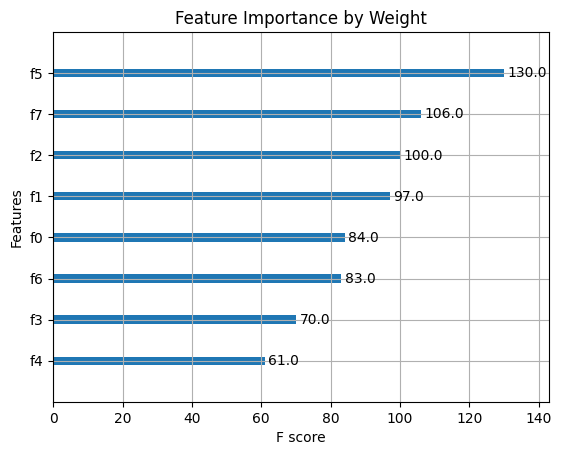

<Figure size 1000x800 with 0 Axes>

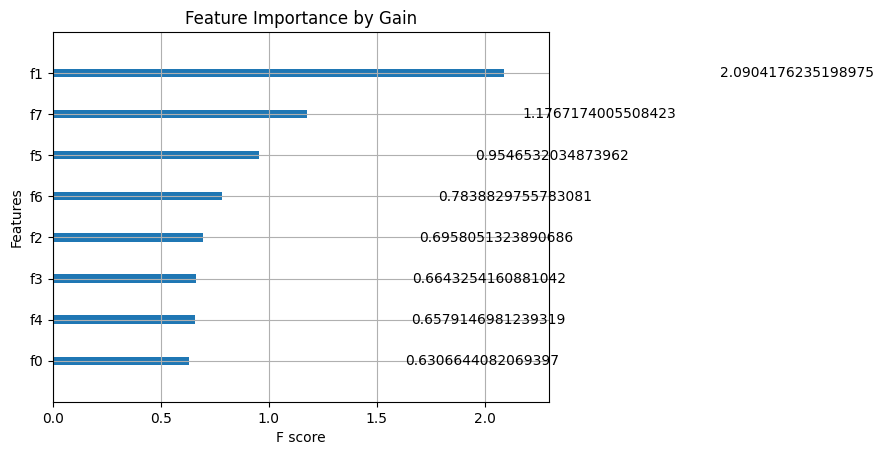

<Figure size 1000x800 with 0 Axes>

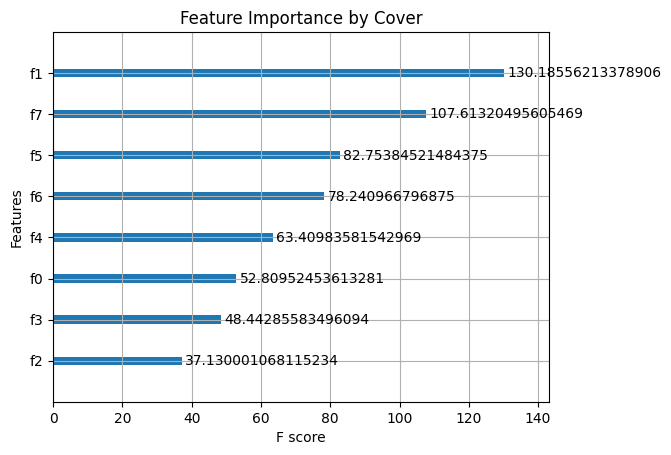

  Feature  Weight
5      f5   130.0
7      f7   106.0
2      f2   100.0
1      f1    97.0
0      f0    84.0
6      f6    83.0
3      f3    70.0
4      f4    61.0


<Figure size 1000x800 with 0 Axes>

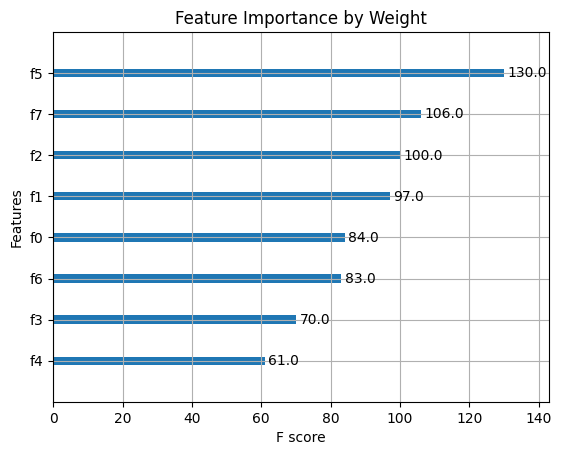

In [16]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the model from the JSON file
model_path = './model/xgb_model.json'
booster = xgb.Booster()
booster.load_model(model_path)
# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(booster, importance_type='weight')
plt.title('Feature Importance by Weight')
plt.show()

# For more detailed feature importance, you can also use 'gain' or 'cover'
plt.figure(figsize=(10, 8))
xgb.plot_importance(booster, importance_type='gain')
plt.title('Feature Importance by Gain')
plt.show()

plt.figure(figsize=(10, 8))
xgb.plot_importance(booster, importance_type='cover')
plt.title('Feature Importance by Cover')
plt.show()


# Get feature importance scores
importance_scores = booster.get_score(importance_type='weight')
# Convert to a DataFrame for better visualization and sorting
importance_df = pd.DataFrame(importance_scores.items(), columns=['Feature', 'Weight'])

# Sort features by importance
importance_df = importance_df.sort_values(by='Weight', ascending=False)

# Display the sorted feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(booster, importance_type='weight')
plt.title('Feature Importance by Weight')
plt.show()

This indicates that the most important features for our model are : Insulin, DPF, Pregnancies, Glucose.

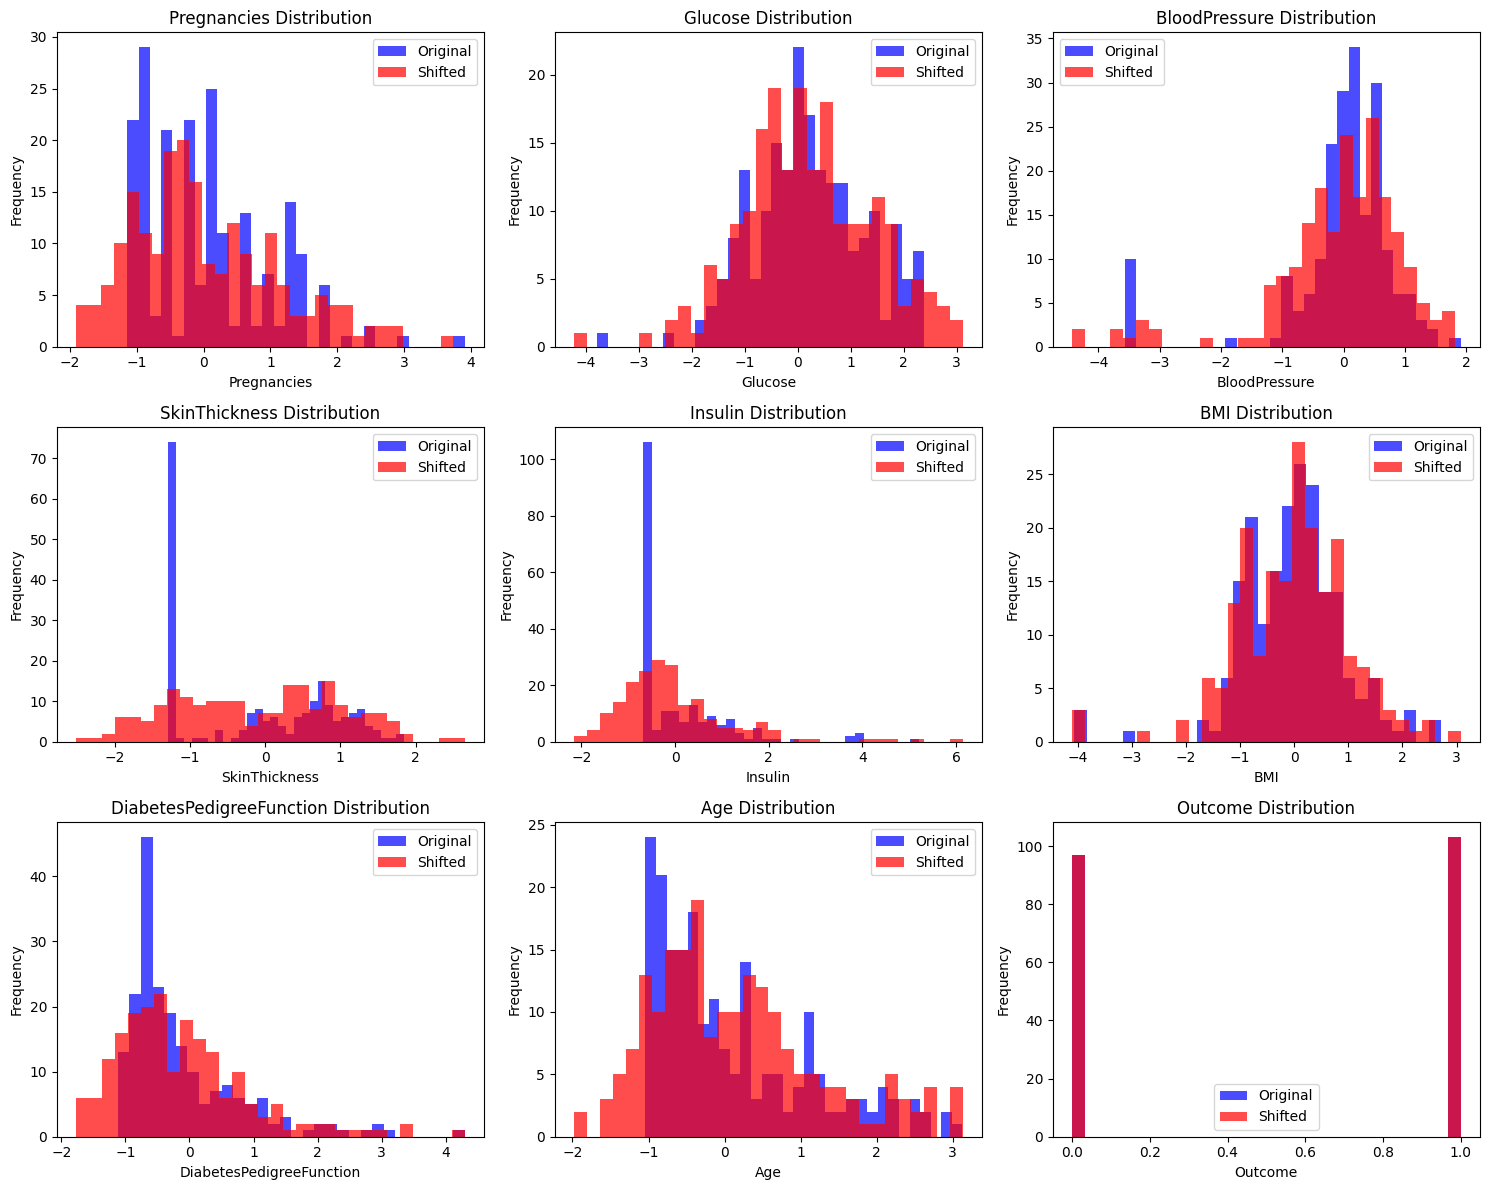

                          KS Statistic       p-value
Pregnancies                      0.120  1.122836e-01
Glucose                          0.065  7.933622e-01
BloodPressure                    0.145  2.971482e-02
SkinThickness                    0.205  4.306111e-04
Insulin                          0.285  1.463948e-07
BMI                              0.070  7.125821e-01
DiabetesPedigreeFunction         0.175  4.304993e-03
Age                              0.120  1.122836e-01
Outcome                          0.000  1.000000e+00


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load datasets from CSV files
original_dataset_path = './datasets/test_dataset.csv'
shifted_dataset_path = './datasets/shifted_test_dataset_intensity_0.5.csv'

original_df = pd.read_csv(original_dataset_path)
shifted_df = pd.read_csv(shifted_dataset_path)

# Ensure both datasets have the same columns
assert list(original_df.columns) == list(shifted_df.columns), "Datasets must have the same columns"

# Plot distributions of each feature
def plot_distributions(original, shifted, features):
    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        plt.hist(original[feature], bins=30, alpha=0.7, color='blue', label='Original')
        plt.hist(shifted[feature], bins=30, alpha=0.7, color='red', label='Shifted')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

features = original_df.columns
plot_distributions(original_df, shifted_df, features)

# Perform KS test for each feature
ks_results = {}
for feature in features:
    ks_statistic, ks_pvalue = ks_2samp(original_df[feature], shifted_df[feature])
    ks_results[feature] = {'KS Statistic': ks_statistic, 'p-value': ks_pvalue}

# Convert KS results to DataFrame for better visualization
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)


Intensity 0.5 : 
different features : Insulin, DPF

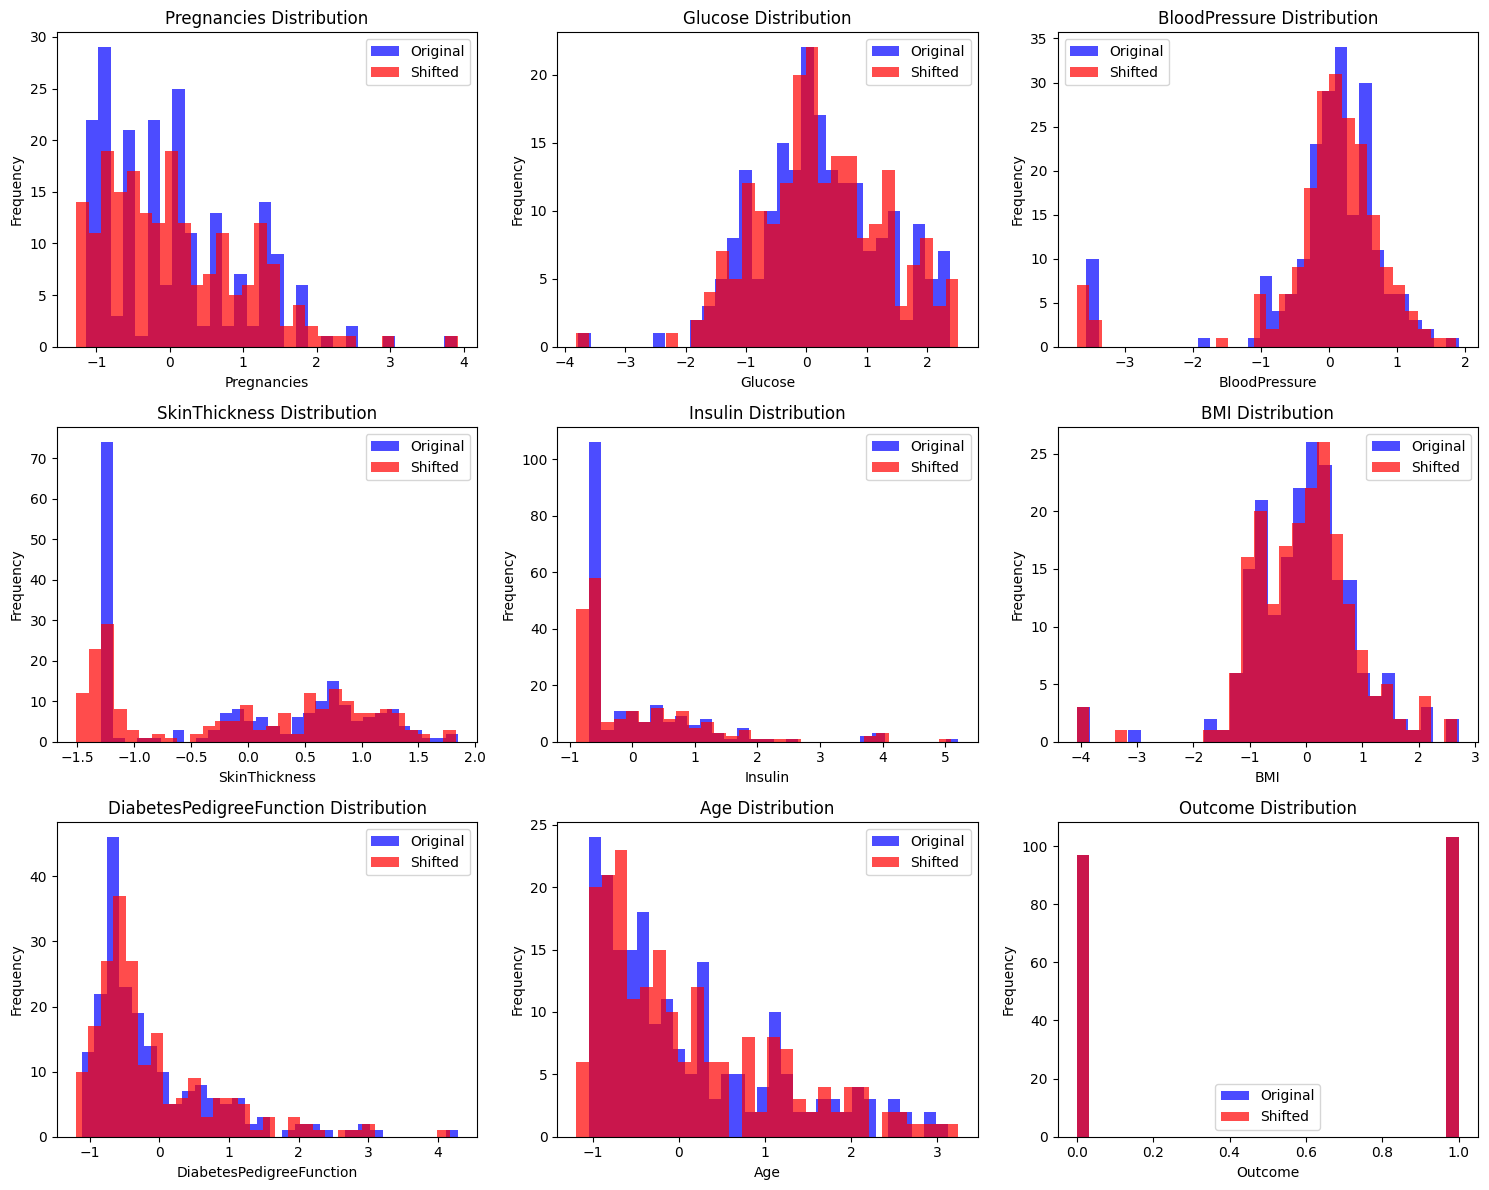

                          KS Statistic       p-value
Pregnancies                      0.085  4.662864e-01
Glucose                          0.030  9.999921e-01
BloodPressure                    0.055  9.238374e-01
SkinThickness                    0.200  6.486080e-04
Insulin                          0.290  8.114130e-08
BMI                              0.030  9.999921e-01
DiabetesPedigreeFunction         0.045  9.877895e-01
Age                              0.045  9.877895e-01
Outcome                          0.000  1.000000e+00


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load datasets from CSV files
original_dataset_path = './datasets/test_dataset.csv'
shifted_dataset_path = './datasets/shifted_test_dataset_intensity_0.1.csv'

original_df = pd.read_csv(original_dataset_path)
shifted_df = pd.read_csv(shifted_dataset_path)

# Ensure both datasets have the same columns
assert list(original_df.columns) == list(shifted_df.columns), "Datasets must have the same columns"

# Plot distributions of each feature
def plot_distributions(original, shifted, features):
    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        plt.hist(original[feature], bins=30, alpha=0.7, color='blue', label='Original')
        plt.hist(shifted[feature], bins=30, alpha=0.7, color='red', label='Shifted')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

features = original_df.columns
plot_distributions(original_df, shifted_df, features)

# Perform KS test for each feature
ks_results = {}
for feature in features:
    ks_statistic, ks_pvalue = ks_2samp(original_df[feature], shifted_df[feature])
    ks_results[feature] = {'KS Statistic': ks_statistic, 'p-value': ks_pvalue}

# Convert KS results to DataFrame for better visualization
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)


Intensity 0.1 : 
different features : Insulin

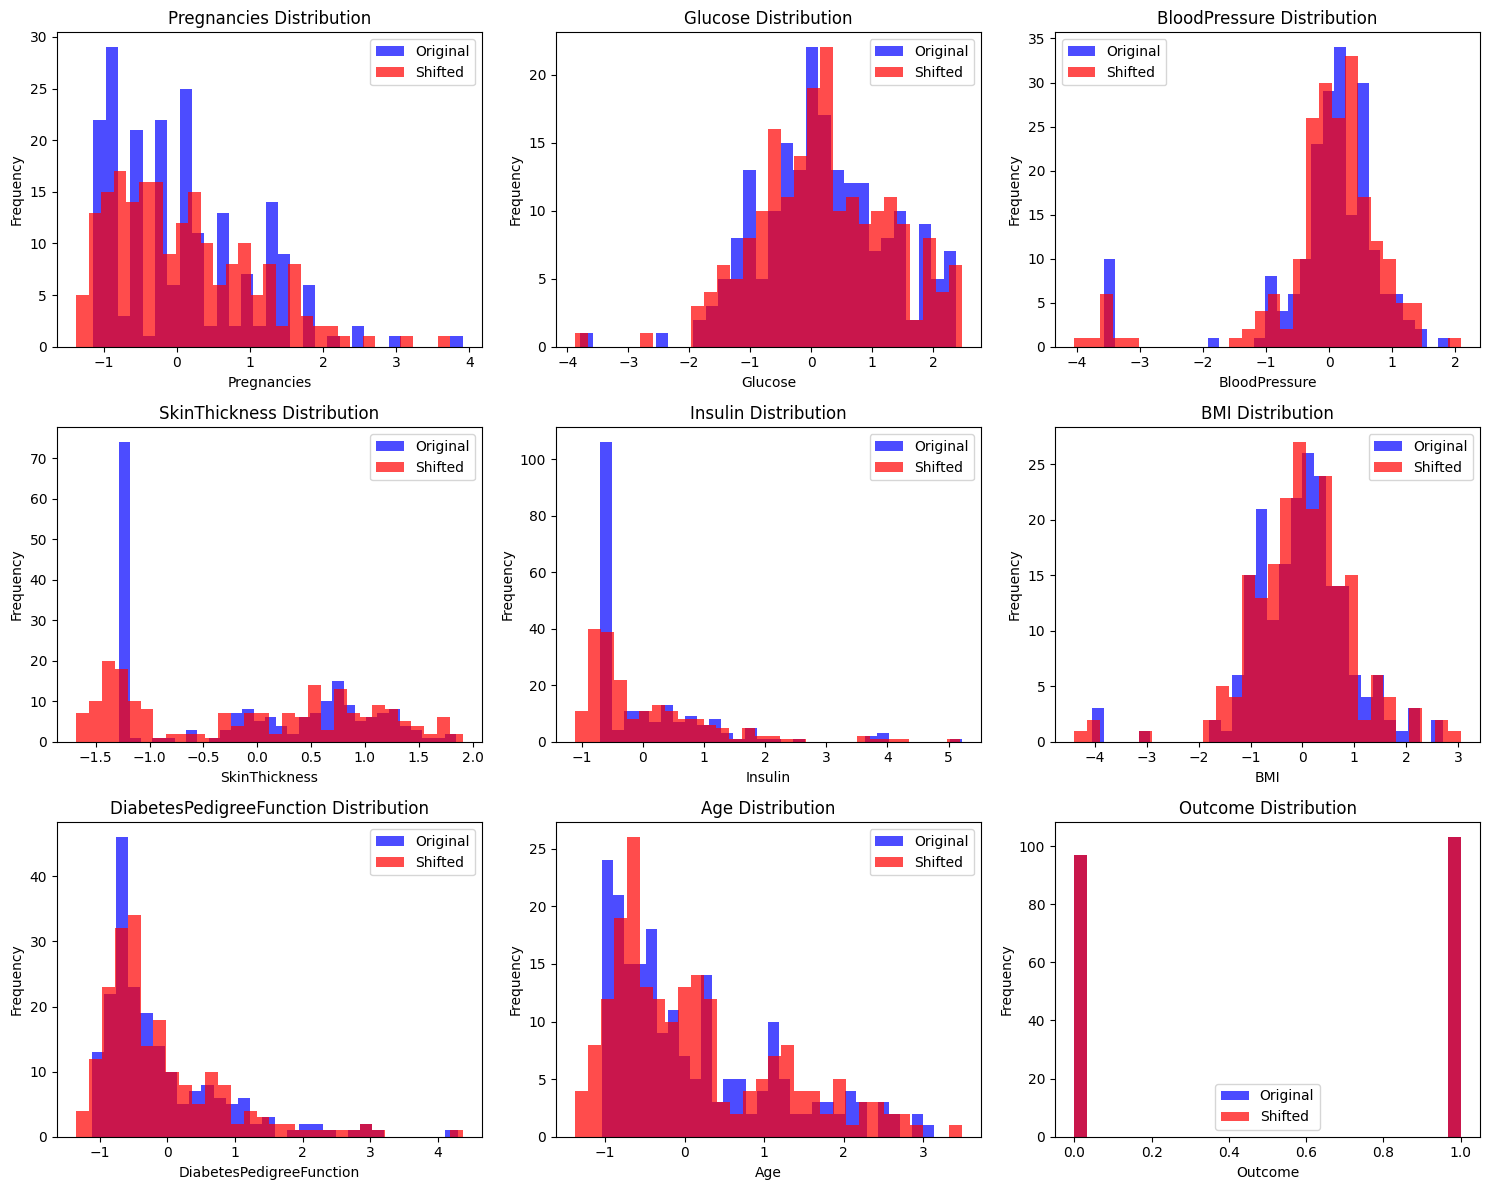

                          KS Statistic       p-value
Pregnancies                      0.090  3.935274e-01
Glucose                          0.035  9.997218e-01
BloodPressure                    0.060  8.655265e-01
SkinThickness                    0.205  4.306111e-04
Insulin                          0.290  8.114130e-08
BMI                              0.060  8.655265e-01
DiabetesPedigreeFunction         0.060  8.655265e-01
Age                              0.085  4.662864e-01
Outcome                          0.000  1.000000e+00


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load datasets from CSV files
original_dataset_path = './datasets/test_dataset.csv'
shifted_dataset_path = './datasets/shifted_test_dataset_intensity_0.2.csv'

original_df = pd.read_csv(original_dataset_path)
shifted_df = pd.read_csv(shifted_dataset_path)

# Ensure both datasets have the same columns
assert list(original_df.columns) == list(shifted_df.columns), "Datasets must have the same columns"

# Plot distributions of each feature
def plot_distributions(original, shifted, features):
    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        plt.hist(original[feature], bins=30, alpha=0.7, color='blue', label='Original')
        plt.hist(shifted[feature], bins=30, alpha=0.7, color='red', label='Shifted')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

features = original_df.columns
plot_distributions(original_df, shifted_df, features)

# Perform KS test for each feature
ks_results = {}
for feature in features:
    ks_statistic, ks_pvalue = ks_2samp(original_df[feature], shifted_df[feature])
    ks_results[feature] = {'KS Statistic': ks_statistic, 'p-value': ks_pvalue}

# Convert KS results to DataFrame for better visualization
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)


Intensity 0.2
Features: Insulin

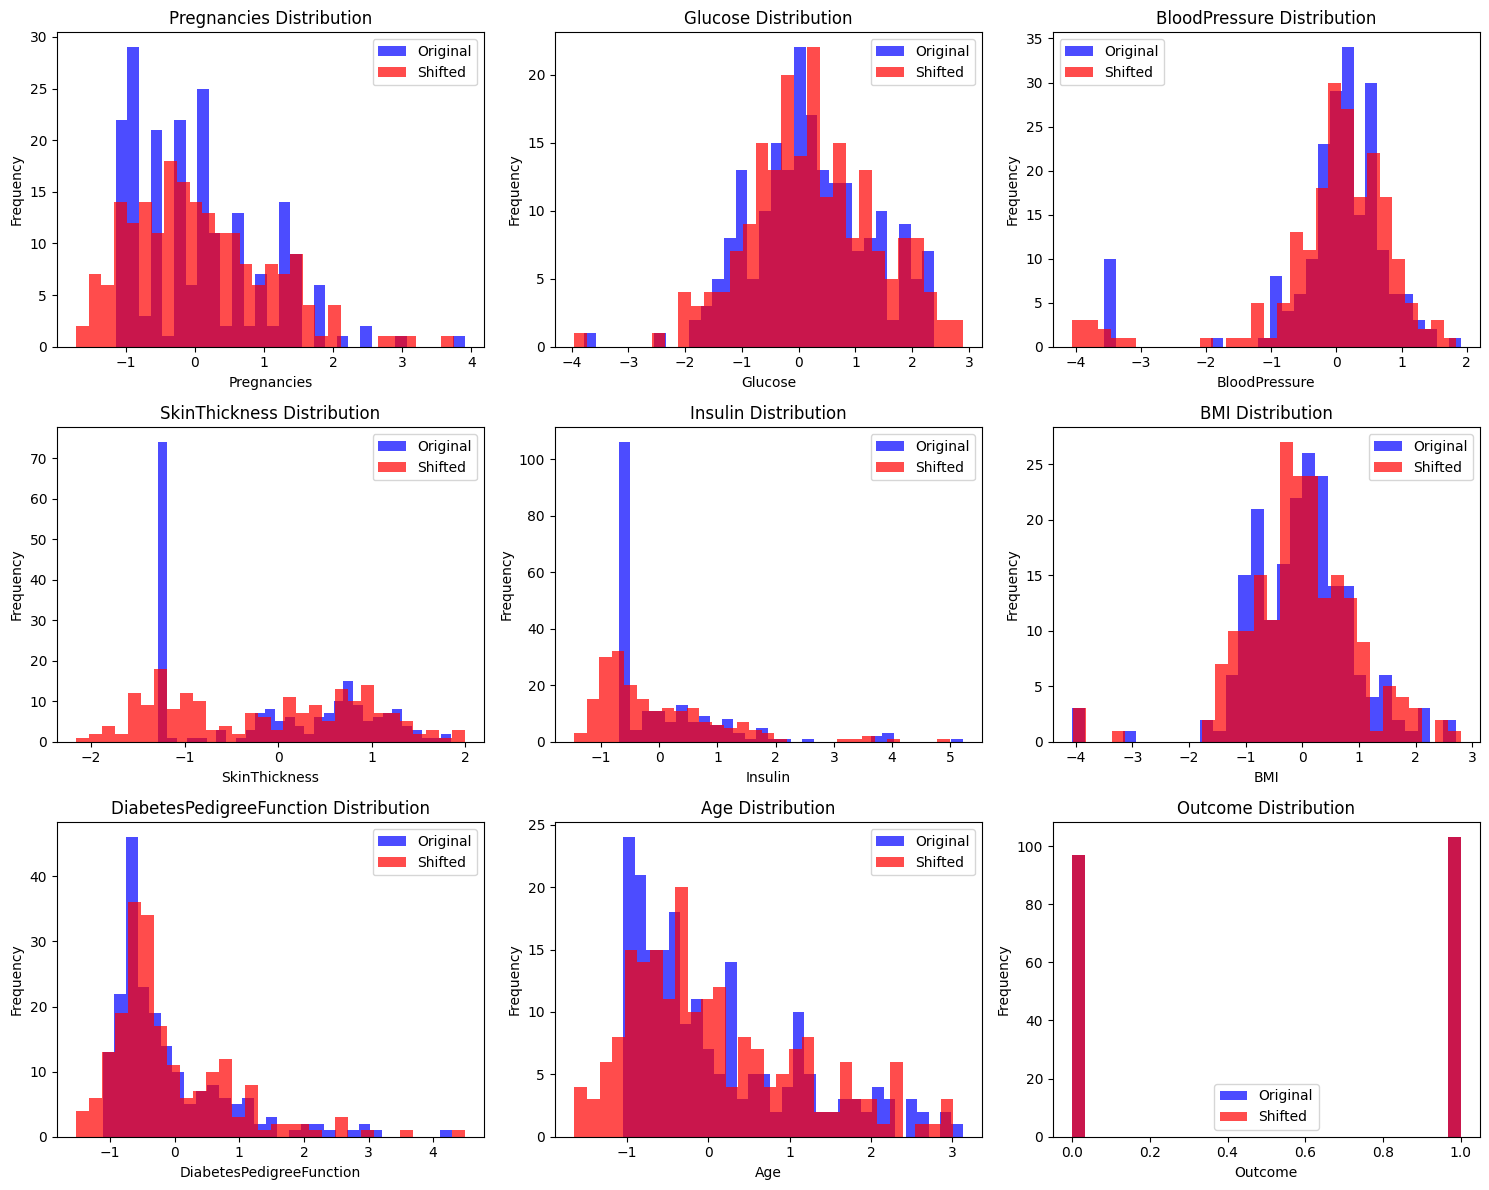

                          KS Statistic       p-value
Pregnancies                      0.085  4.662864e-01
Glucose                          0.060  8.655265e-01
BloodPressure                    0.105  2.205412e-01
SkinThickness                    0.205  4.306111e-04
Insulin                          0.320  1.869465e-09
BMI                              0.060  8.655265e-01
DiabetesPedigreeFunction         0.085  4.662864e-01
Age                              0.095  3.281154e-01
Outcome                          0.000  1.000000e+00


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load datasets from CSV files
original_dataset_path = './datasets/test_dataset.csv'
shifted_dataset_path = './datasets/shifted_test_dataset_intensity_0.3.csv'

original_df = pd.read_csv(original_dataset_path)
shifted_df = pd.read_csv(shifted_dataset_path)

# Ensure both datasets have the same columns
assert list(original_df.columns) == list(shifted_df.columns), "Datasets must have the same columns"

# Plot distributions of each feature
def plot_distributions(original, shifted, features):
    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        plt.hist(original[feature], bins=30, alpha=0.7, color='blue', label='Original')
        plt.hist(shifted[feature], bins=30, alpha=0.7, color='red', label='Shifted')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

features = original_df.columns
plot_distributions(original_df, shifted_df, features)

# Perform KS test for each feature
ks_results = {}
for feature in features:
    ks_statistic, ks_pvalue = ks_2samp(original_df[feature], shifted_df[feature])
    ks_results[feature] = {'KS Statistic': ks_statistic, 'p-value': ks_pvalue}

# Convert KS results to DataFrame for better visualization
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)


Intensity 0.3
Features: Insulin

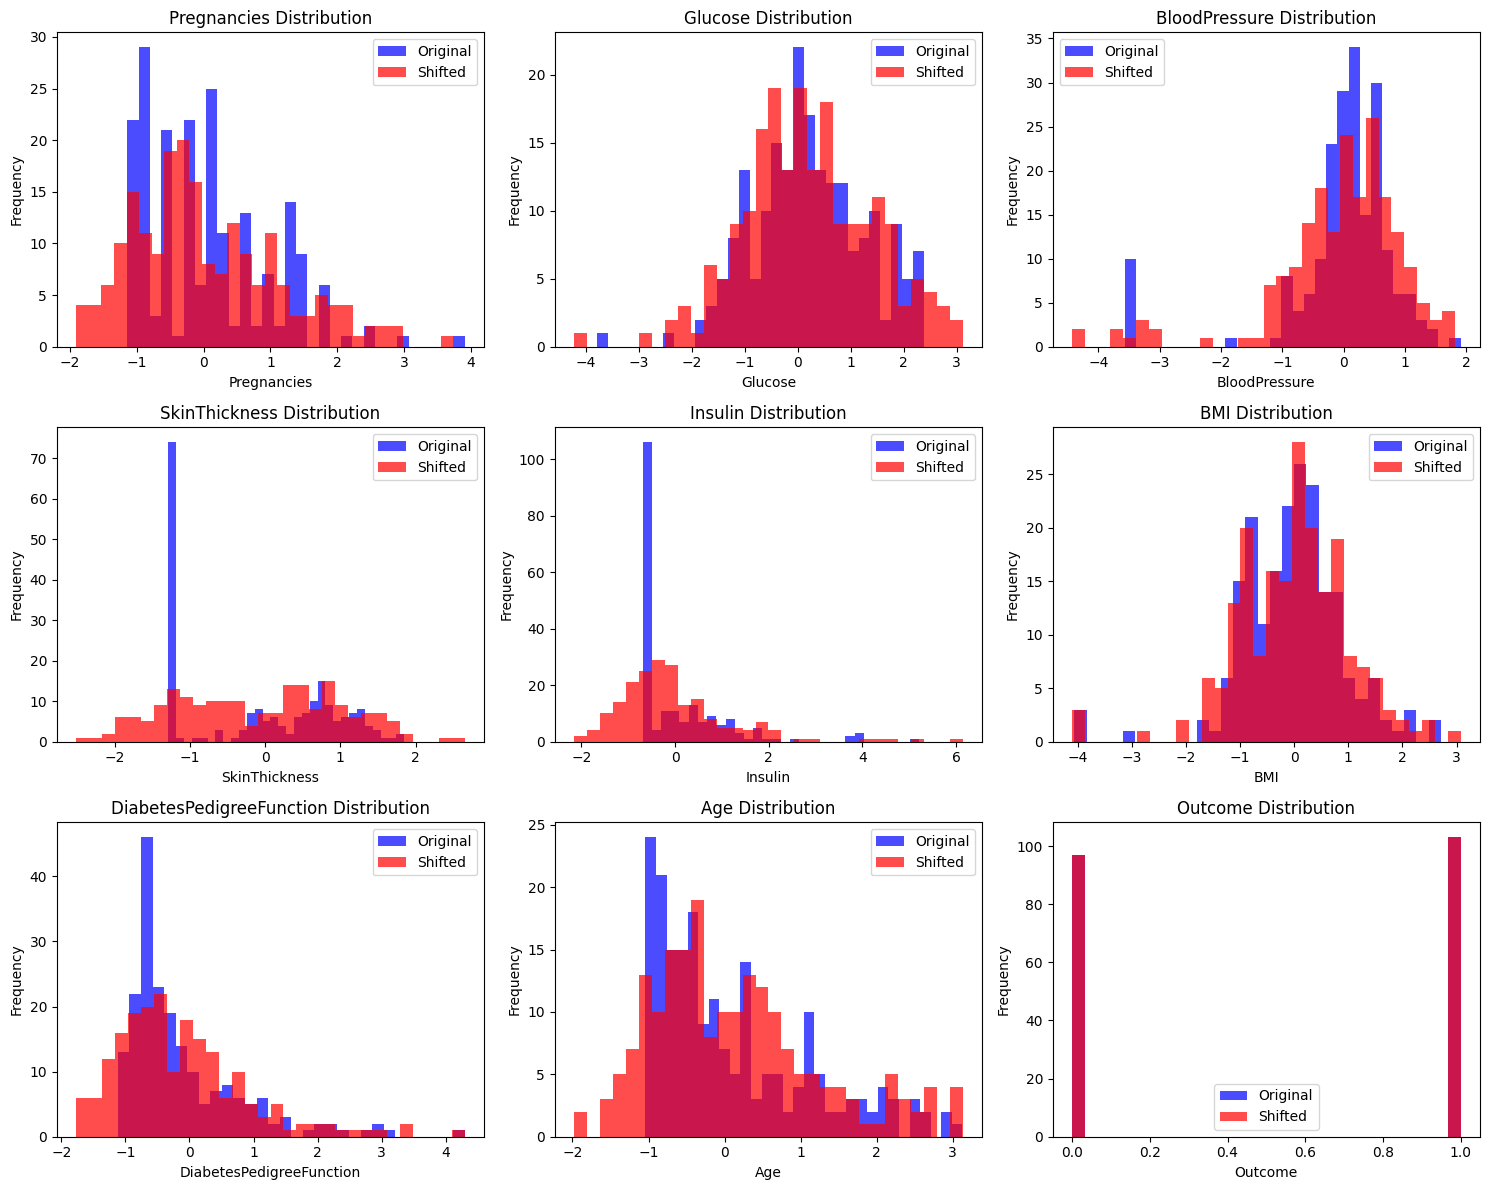

                          KS Statistic       p-value
Pregnancies                      0.120  1.122836e-01
Glucose                          0.065  7.933622e-01
BloodPressure                    0.145  2.971482e-02
SkinThickness                    0.205  4.306111e-04
Insulin                          0.285  1.463948e-07
BMI                              0.070  7.125821e-01
DiabetesPedigreeFunction         0.175  4.304993e-03
Age                              0.120  1.122836e-01
Outcome                          0.000  1.000000e+00


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load datasets from CSV files
original_dataset_path = './datasets/test_dataset.csv'
shifted_dataset_path = './datasets/shifted_test_dataset_intensity_0.5.csv'

original_df = pd.read_csv(original_dataset_path)
shifted_df = pd.read_csv(shifted_dataset_path)

# Ensure both datasets have the same columns
assert list(original_df.columns) == list(shifted_df.columns), "Datasets must have the same columns"

# Plot distributions of each feature
def plot_distributions(original, shifted, features):
    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        plt.hist(original[feature], bins=30, alpha=0.7, color='blue', label='Original')
        plt.hist(shifted[feature], bins=30, alpha=0.7, color='red', label='Shifted')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

features = original_df.columns
plot_distributions(original_df, shifted_df, features)

# Perform KS test for each feature
ks_results = {}
for feature in features:
    ks_statistic, ks_pvalue = ks_2samp(original_df[feature], shifted_df[feature])
    ks_results[feature] = {'KS Statistic': ks_statistic, 'p-value': ks_pvalue}

# Convert KS results to DataFrame for better visualization
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)


Intensity : 0.5
Features : Insluin, DPF

In [23]:
import pandas as pd
import numpy as np

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Important features in order
important_features = ['Glucose', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin']

# Define a function to add Gaussian noise to a feature
def add_gaussian_noise(data, feature, intensity=0.3):
    noise = np.random.normal(0, intensity, data[feature].shape)
    data[feature] += noise
    return data

# Shift features one by one and save datasets
for i, feature in enumerate(important_features):
    # Copy the original dataset
    shifted_df = df.copy()
    # Add noise to the current and all previous important features
    for j in range(i + 1):
        shifted_df = add_gaussian_noise(shifted_df, important_features[j])
    # Save the shifted dataset
    shifted_df.to_csv(f'./datasets/shifted_dataset_up_to_{feature}.csv', index=False)
    print(f'Saved shifted dataset with noise added to features up to: {feature}')

print("Shifting complete and datasets saved.")


Saved shifted dataset with noise added to features up to: Glucose
Saved shifted dataset with noise added to features up to: Pregnancies
Saved shifted dataset with noise added to features up to: DiabetesPedigreeFunction
Saved shifted dataset with noise added to features up to: Insulin
Shifting complete and datasets saved.


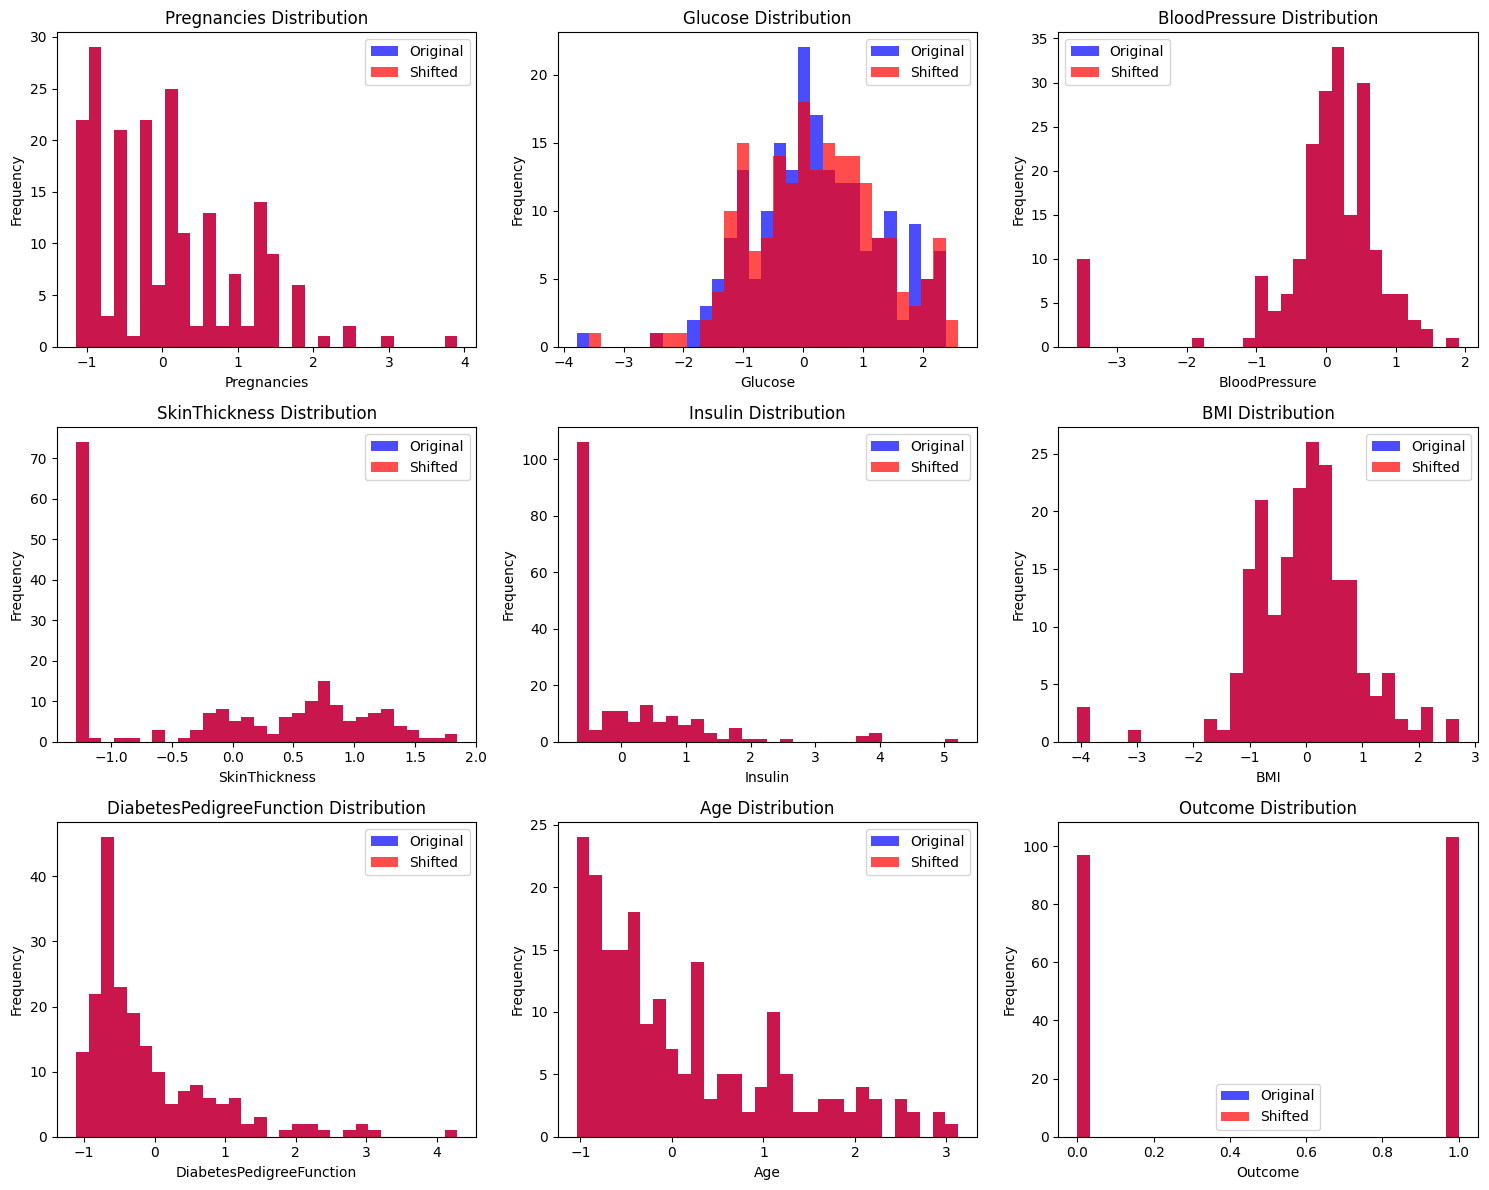

                          KS Statistic   p-value
Pregnancies                      0.000  1.000000
Glucose                          0.055  0.923837
BloodPressure                    0.000  1.000000
SkinThickness                    0.000  1.000000
Insulin                          0.000  1.000000
BMI                              0.000  1.000000
DiabetesPedigreeFunction         0.005  1.000000
Age                              0.005  1.000000
Outcome                          0.000  1.000000


c:\Users\lyna\anaconda3\envs\det3pa\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load datasets from CSV files
original_dataset_path = './datasets/test_dataset.csv'
shifted_dataset_path = './datasets/shifted_dataset_up_to_Glucose.csv'

original_df = pd.read_csv(original_dataset_path)
shifted_df = pd.read_csv(shifted_dataset_path)

# Ensure both datasets have the same columns
assert list(original_df.columns) == list(shifted_df.columns), "Datasets must have the same columns"

# Plot distributions of each feature
def plot_distributions(original, shifted, features):
    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        plt.hist(original[feature], bins=30, alpha=0.7, color='blue', label='Original')
        plt.hist(shifted[feature], bins=30, alpha=0.7, color='red', label='Shifted')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

features = original_df.columns
plot_distributions(original_df, shifted_df, features)

# Perform KS test for each feature
ks_results = {}
for feature in features:
    ks_statistic, ks_pvalue = ks_2samp(original_df[feature], shifted_df[feature])
    ks_results[feature] = {'KS Statistic': ks_statistic, 'p-value': ks_pvalue}

# Convert KS results to DataFrame for better visualization
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)


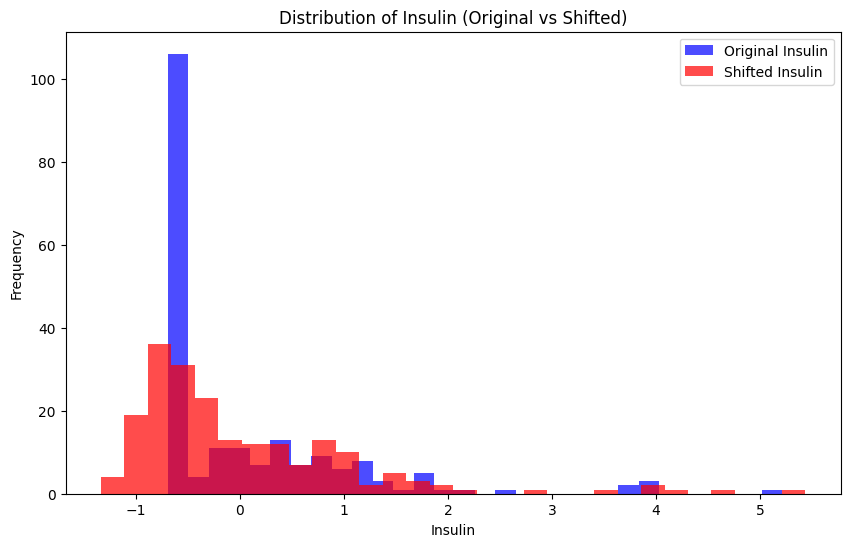

Original Insulin Stats:
count    200.000000
mean       0.009037
std        1.052760
min       -0.692891
25%       -0.692891
50%       -0.692891
75%        0.440227
max        5.211479
Name: Insulin, dtype: float64

Shifted Insulin Stats:
count    200.000000
mean       0.011579
std        1.086693
min       -1.334587
25%       -0.730557
50%       -0.354455
75%        0.442771
max        5.433828
Name: Insulin, dtype: float64

KS test for Insulin - Statistic: 0.275, p-value: 4.6128382074998843e-07


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Check the statistics and distribution of the Glucose feature before and after adding Gaussian noise
def add_gaussian_noise(data, feature, intensity=0.5):
    noise = np.random.normal(0, intensity, data[feature].shape)
    data[feature] += noise
    return data

# Add noise to the Glucose feature
original_glucose = df['Insulin'].copy()
shifted_df = df.copy()
shifted_df = add_gaussian_noise(shifted_df, 'Insulin', intensity=0.3)
shifted_glucose = shifted_df['Insulin']

# Perform KS test
ks_statistic, ks_pvalue = ks_2samp(original_glucose, shifted_glucose)

# Display statistics and KS test result
original_stats = original_glucose.describe()
shifted_stats = shifted_glucose.describe()

# Plot the original and shifted distributions
plt.figure(figsize=(10, 6))
plt.hist(original_glucose, bins=30, alpha=0.7, color='blue', label='Original Insulin')
plt.hist(shifted_glucose, bins=30, alpha=0.7, color='red', label='Shifted Insulin')
plt.title('Distribution of Insulin (Original vs Shifted)')
plt.xlabel('Insulin')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print("Original Insulin Stats:")
print(original_stats)
print("\nShifted Insulin Stats:")
print(shifted_stats)
print(f"\nKS test for Insulin - Statistic: {ks_statistic}, p-value: {ks_pvalue}")


In [79]:
import pandas as pd
import numpy as np

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Important features in order
important_features = ['Glucose', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin']

# Specify intensities for each feature
intensities = {
    'Glucose': 1.5,
    'Pregnancies': 1.,
    'DiabetesPedigreeFunction': 1.6,
    'Insulin': 1.15
}

# Define a function to add Gaussian noise to a feature with a specified intensity
def add_gaussian_noise(data, feature, intensity):
    noise = np.random.normal(2, intensity, data[feature].shape)
    data[feature] += noise
    return data

def add_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_features(data, feature, factor):
    data[feature] *= factor
    return data

# Shift features one by one and save datasets
for i, feature in enumerate(important_features):
    # Copy the original dataset
    shifted_df = df.copy()
    # Add noise to the current and all previous important features
    shifted_df = scale_features(shifted_df, important_features[i], intensities[important_features[i]])
    # Save the shifted dataset
    shifted_df.to_csv(f'./datasets/shifted_dataset_{feature}.csv', index=False)
    print(f'Saved shifted dataset with noise added to features up to: {feature}')

print("Shifting complete and datasets saved.")


Saved shifted dataset with noise added to features up to: Glucose
Saved shifted dataset with noise added to features up to: Pregnancies
Saved shifted dataset with noise added to features up to: DiabetesPedigreeFunction
Saved shifted dataset with noise added to features up to: Insulin
Shifting complete and datasets saved.


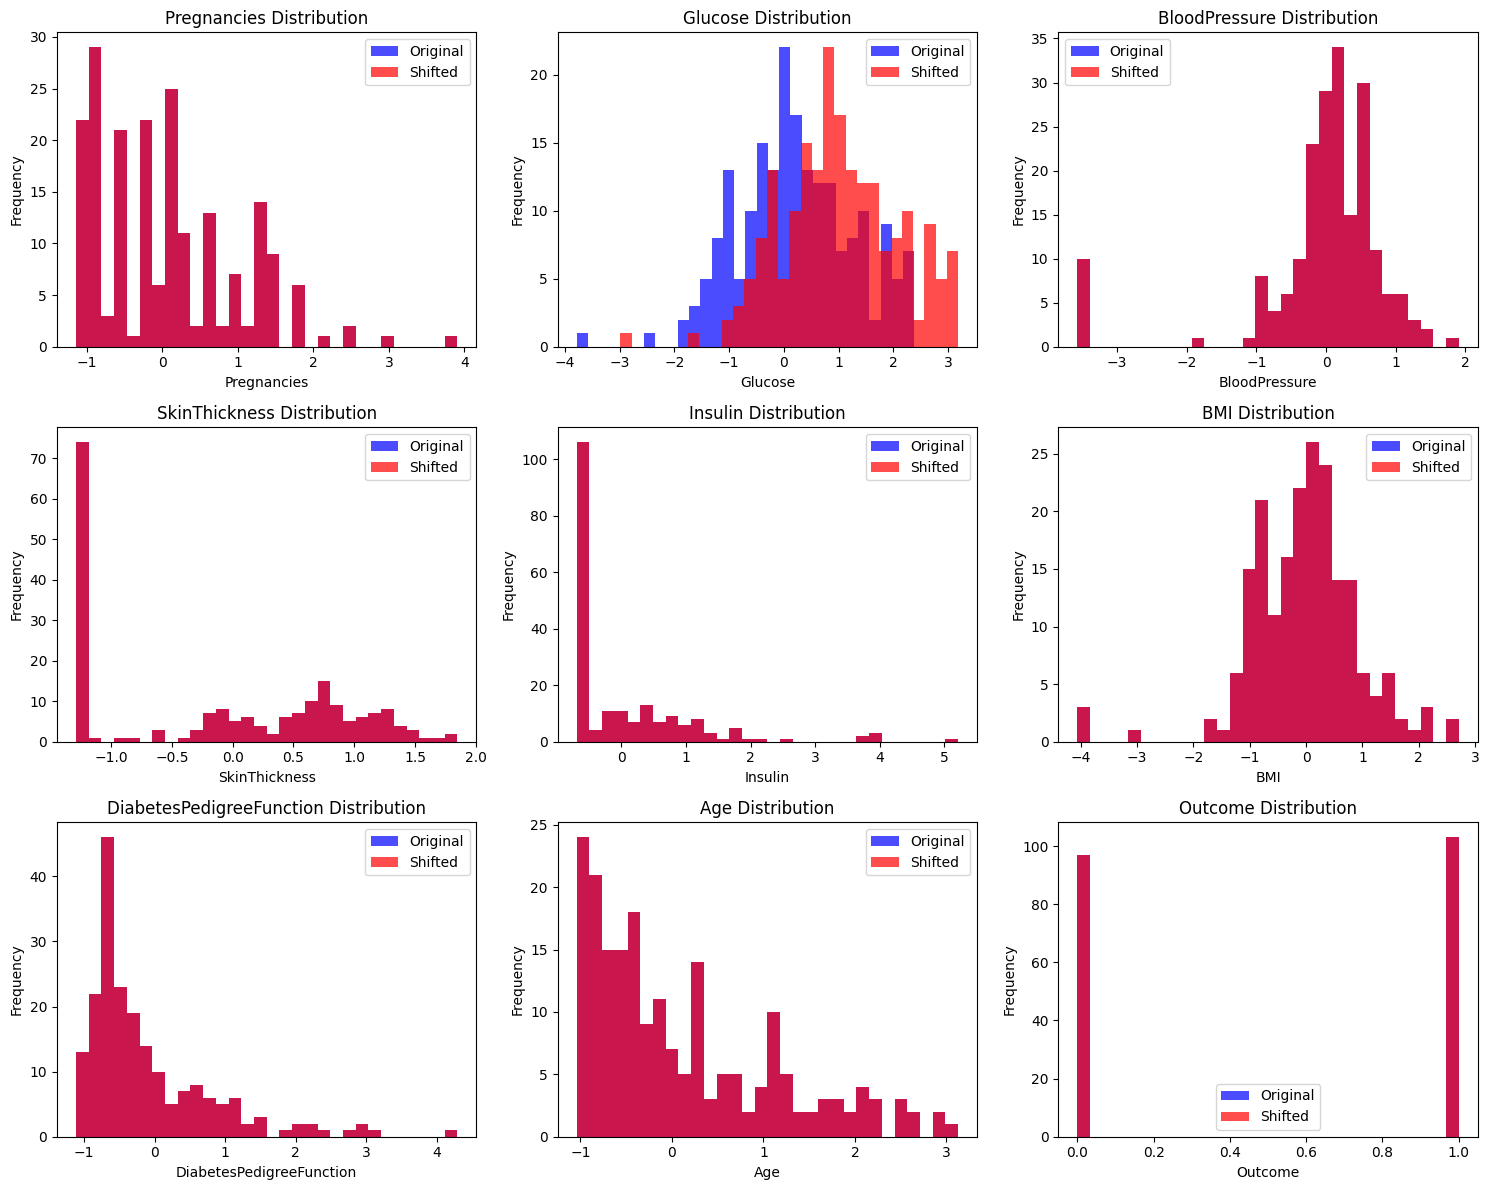

                          KS Statistic       p-value
Pregnancies                      0.000  1.000000e+00
Glucose                          0.335  2.443746e-10
BloodPressure                    0.000  1.000000e+00
SkinThickness                    0.000  1.000000e+00
Insulin                          0.000  1.000000e+00
BMI                              0.000  1.000000e+00
DiabetesPedigreeFunction         0.005  1.000000e+00
Age                              0.005  1.000000e+00
Outcome                          0.000  1.000000e+00


c:\Users\lyna\anaconda3\envs\det3pa\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load datasets from CSV files
original_dataset_path = './datasets/test_dataset.csv'
shifted_dataset_path = './datasets/shifted_dataset_Glucose.csv'

original_df = pd.read_csv(original_dataset_path)
shifted_df = pd.read_csv(shifted_dataset_path)

# Ensure both datasets have the same columns
assert list(original_df.columns) == list(shifted_df.columns), "Datasets must have the same columns"

# Plot distributions of each feature
def plot_distributions(original, shifted, features):
    plt.figure(figsize=(15, 12))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i + 1)
        plt.hist(original[feature], bins=30, alpha=0.7, color='blue', label='Original')
        plt.hist(shifted[feature], bins=30, alpha=0.7, color='red', label='Shifted')
        plt.title(f'{feature} Distribution')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    plt.tight_layout()
    plt.show()

features = original_df.columns
plot_distributions(original_df, shifted_df, features)

# Perform KS test for each feature
ks_results = {}
for feature in features:
    ks_statistic, ks_pvalue = ks_2samp(original_df[feature], shifted_df[feature])
    ks_results[feature] = {'KS Statistic': ks_statistic, 'p-value': ks_pvalue}

# Convert KS results to DataFrame for better visualization
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)


Feature: Glucose
AUC: Original=0.8886998298468622, Shifted=0.8678810929836853
Accuracy: Original=0.81, Shifted=0.81
KS Statistic: 0.05, p-value: 0.9646522162314058




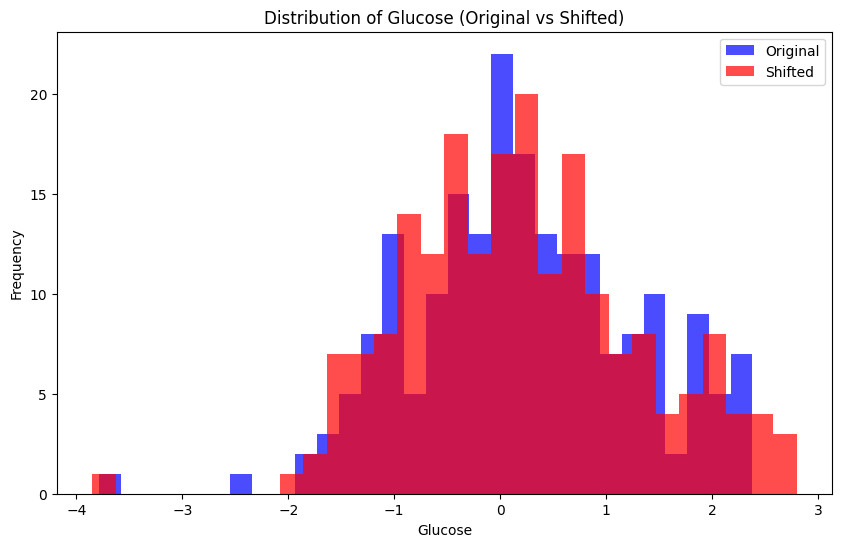

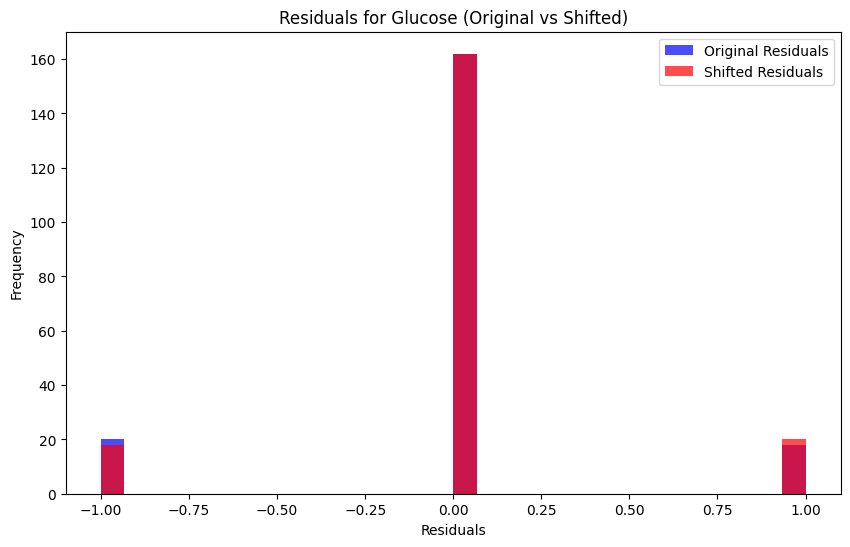

Feature: Pregnancies
AUC: Original=0.8886998298468622, Shifted=0.892503252927635
Accuracy: Original=0.81, Shifted=0.82
KS Statistic: 0.115, p-value: 0.1420746514551761




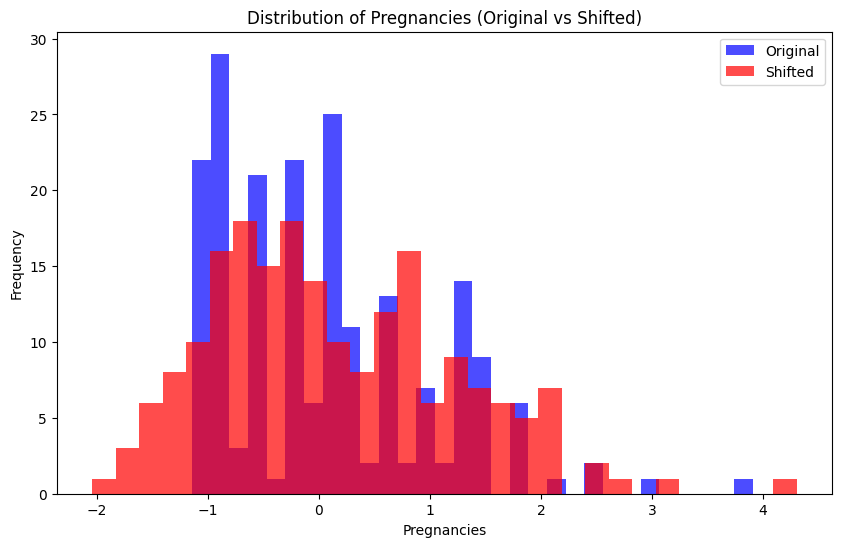

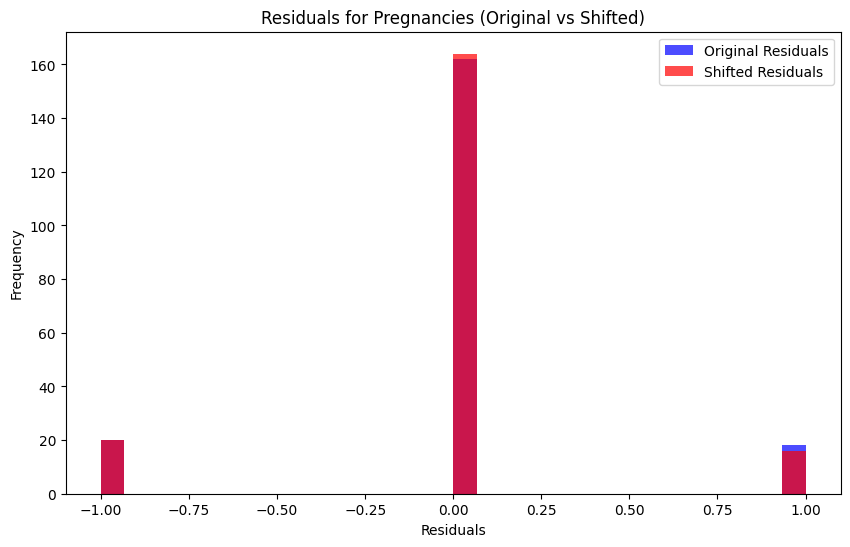

Feature: DiabetesPedigreeFunction
AUC: Original=0.8886998298468622, Shifted=0.8903012711440296
Accuracy: Original=0.81, Shifted=0.8
KS Statistic: 0.06, p-value: 0.8655265369450457




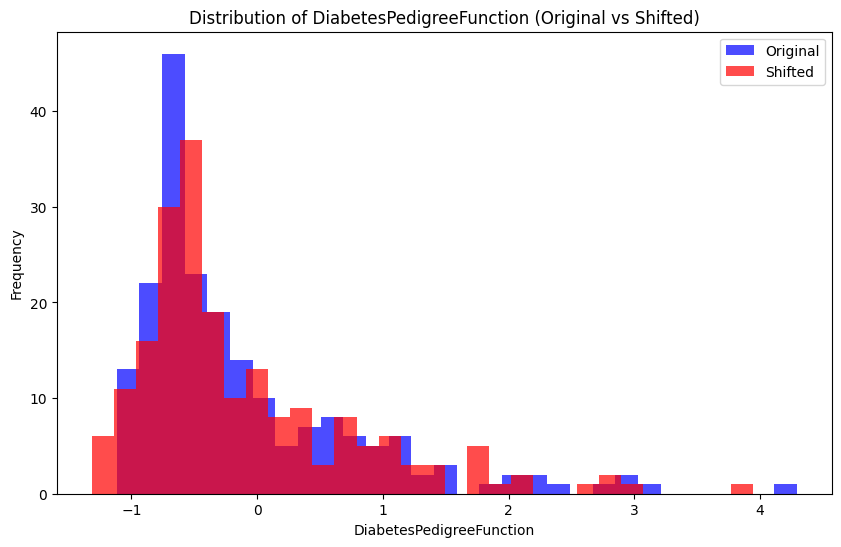

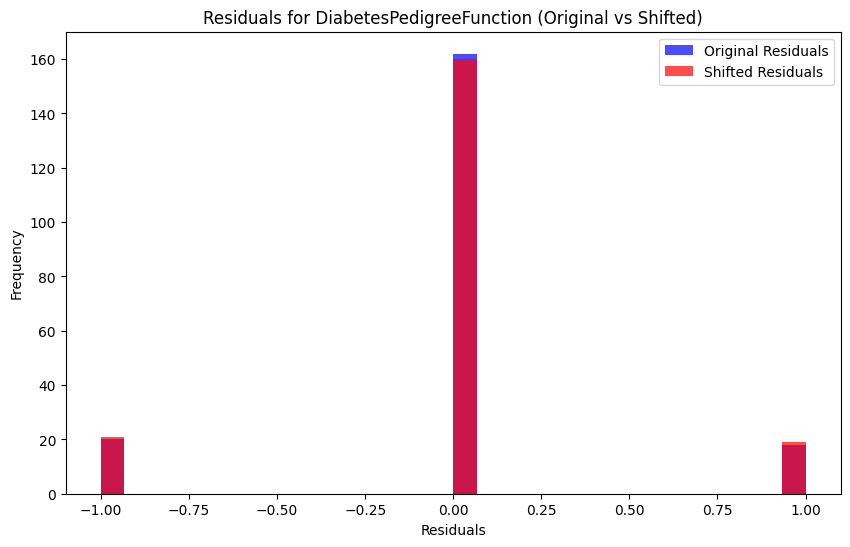

Feature: Insulin
AUC: Original=0.8886998298468622, Shifted=0.8866980282254029
Accuracy: Original=0.81, Shifted=0.805
KS Statistic: 0.3, p-value: 2.4125498977354686e-08




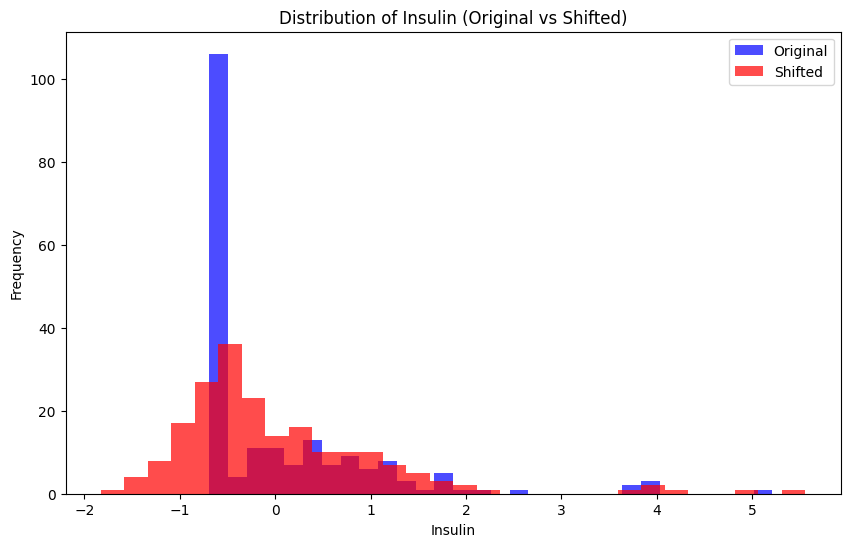

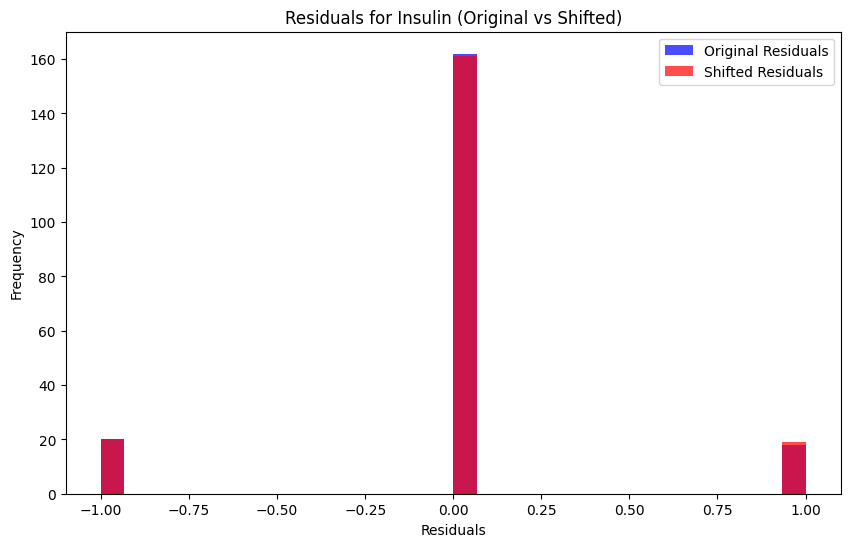

                    Feature  Intensity  Original AUC  Shifted AUC  \
0                   Glucose        0.3        0.8887     0.867881   
1               Pregnancies        0.5        0.8887     0.892503   
2  DiabetesPedigreeFunction        0.2        0.8887     0.890301   
3                   Insulin        0.4        0.8887     0.886698   

   Original Accuracy  Shifted Accuracy  KS Statistic    KS p-value  
0               0.81             0.810         0.050  9.646522e-01  
1               0.81             0.820         0.115  1.420747e-01  
2               0.81             0.800         0.060  8.655265e-01  
3               0.81             0.805         0.300  2.412550e-08  


In [103]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Important features and specified intensities
important_features = {
    'Glucose': 0.3,
    'Pregnancies': 0.5,
    'DiabetesPedigreeFunction': 0.2,
    'Insulin': 0.4
}

# Load the model
model_path = './model/xgb_model.json'
booster = xgb.Booster()
booster.load_model(model_path)

# Define a function to add Gaussian noise to a feature
def add_gaussian_noise(data, feature, intensity):
    noise = np.random.normal(0, intensity, data[feature].shape)
    data[feature] += noise
    return data

# Define a function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    return auc, accuracy, y_pred

# Prepare test data
X_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

# Log the original performance
original_auc, original_accuracy, original_pred = evaluate_model_performance(booster, X_test, y_test)
performance_log = []

# Evaluate performance for each feature shift
for feature, intensity in important_features.items():
    shifted_df = df.copy()
    shifted_df = add_gaussian_noise(shifted_df, feature, intensity)
    X_test_shifted = shifted_df.drop(columns=['Outcome'])
    auc, accuracy, shifted_pred = evaluate_model_performance(booster, X_test_shifted, y_test)
    
    # Perform KS test
    ks_statistic, ks_pvalue = ks_2samp(df[feature], shifted_df[feature])
    
    # Log performance changes
    performance_log.append({
        'Feature': feature,
        'Intensity': intensity,
        'Original AUC': original_auc,
        'Shifted AUC': auc,
        'Original Accuracy': original_accuracy,
        'Shifted Accuracy': accuracy,
        'KS Statistic': ks_statistic,
        'KS p-value': ks_pvalue
    })
    
    # Print results
    print(f"Feature: {feature}")
    print(f"AUC: Original={original_auc}, Shifted={auc}")
    print(f"Accuracy: Original={original_accuracy}, Shifted={accuracy}")
    print(f"KS Statistic: {ks_statistic}, p-value: {ks_pvalue}")
    print("\n")
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    plt.hist(df[feature], bins=30, alpha=0.7, color='blue', label='Original')
    plt.hist(shifted_df[feature], bins=30, alpha=0.7, color='red', label='Shifted')
    plt.title(f'Distribution of {feature} (Original vs Shifted)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # Plot residuals
    residuals_original = y_test - original_pred
    residuals_shifted = y_test - shifted_pred
    plt.figure(figsize=(10, 6))
    plt.hist(residuals_original, bins=30, alpha=0.7, color='blue', label='Original Residuals')
    plt.hist(residuals_shifted, bins=30, alpha=0.7, color='red', label='Shifted Residuals')
    plt.title(f'Residuals for {feature} (Original vs Shifted)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Convert performance log to DataFrame for better visualization
performance_df = pd.DataFrame(performance_log)
print(performance_df)

# Optionally, save the performance log to a CSV file
performance_df.to_csv('performance_log.csv', index=False)


In [102]:
import pandas as pd
import numpy as np

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Important features and their specified transformations
transformations = {
    'Glucose': {'type': 'bias', 'bias': 0.8},
    'Pregnancies': {'type': 'bias', 'bias': 3},
    'DiabetesPedigreeFunction': {'type': 'bias', 'bias': -3},
    'Insulin': {'type': 'bias', 'bias': 7}
}

# Define transformation functions
def add_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature(data, feature, factor):
    data[feature] *= factor
    return data

# Apply transformations and save datasets
for feature, params in transformations.items():
    # Copy the original dataset
    shifted_df = df.copy()
    
    # Apply the specified transformation
    if params['type'] == 'gaussian_noise':
        shifted_df = add_gaussian_noise(shifted_df, feature, params['mean'], params['std'])
    elif params['type'] == 'bias':
        shifted_df = add_bias(shifted_df, feature, params['bias'])
    elif params['type'] == 'scale':
        shifted_df = scale_feature(shifted_df, feature, params['factor'])
    
    # Save the shifted dataset
    shifted_df.to_csv(f'./datasets/shifted_dataset_{feature}.csv', index=False)
    print(f'Saved shifted dataset with {params['type']} transformation applied to: {feature}')

print("Shifting complete and datasets saved.")


Saved shifted dataset with bias transformation applied to: Glucose
Saved shifted dataset with bias transformation applied to: Pregnancies
Saved shifted dataset with bias transformation applied to: DiabetesPedigreeFunction
Saved shifted dataset with bias transformation applied to: Insulin
Shifting complete and datasets saved.


In [115]:
import pandas as pd
import numpy as np

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Important features and their specified transformations
transformations = {
    'Glucose': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 1.5},
        {'type': 'bias', 'bias': 0.8}
    ],
    'Pregnancies': [
        {'type': 'bias', 'bias': 2},
        {'type': 'scale', 'factor': 1.5}
    ],
    'DiabetesPedigreeFunction': [
        {'type': 'scale', 'factor': 1.6},
        {'type': 'gaussian_noise', 'mean': 0, 'std': 1.5}
    ],
    'Insulin': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 1.15},
        {'type': 'scale', 'factor': 3}
    ]
}

# Define transformation functions
def add_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature(data, feature, factor):
    data[feature] *= factor
    return data

# Apply transformations and save datasets
for feature, transformations_list in transformations.items():
    # Copy the original dataset
    shifted_df = df.copy()
    
    # Apply each transformation in the list sequentially
    for params in transformations_list:
        if params['type'] == 'gaussian_noise':
            shifted_df = add_gaussian_noise(shifted_df, feature, params['mean'], params['std'])
        elif params['type'] == 'bias':
            shifted_df = add_bias(shifted_df, feature, params['bias'])
        elif params['type'] == 'scale':
            shifted_df = scale_feature(shifted_df, feature, params['factor'])
    
    # Save the shifted dataset
    shifted_df.to_csv(f'./datasets/shifted_dataset_{feature}.csv', index=False)
    print(f'Saved shifted dataset with transformations applied to: {feature}')

print("Shifting complete and datasets saved.")


Saved shifted dataset with transformations applied to: Glucose
Saved shifted dataset with transformations applied to: Pregnancies
Saved shifted dataset with transformations applied to: DiabetesPedigreeFunction
Saved shifted dataset with transformations applied to: Insulin
Shifting complete and datasets saved.


In [118]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ks_2samp

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Important features and their specified transformations
transformations = {
    'Glucose': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 1.5},
        {'type': 'bias', 'bias': 0.8}
    ],
    'Pregnancies': [
        {'type': 'bias', 'bias': 2},
        {'type': 'scale', 'factor': 1.5}
    ],
    'DiabetesPedigreeFunction': [
        {'type': 'scale', 'factor': 1.6},
        {'type': 'gaussian_noise', 'mean': 0, 'std': 1.5}
    ],
    'Insulin': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 1.15},
        {'type': 'bias', 'bias': -5},
    ]
}

# Load the model
model_path = './model/xgb_model.json'
booster = xgb.Booster()
booster.load_model(model_path)

# Define transformation functions
def add_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature(data, feature, factor):
    data[feature] *= factor
    return data

# Define a function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    return auc, accuracy, y_pred

# Prepare test data
X_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

# Log the original performance
original_auc, original_accuracy, original_pred = evaluate_model_performance(booster, X_test, y_test)
print(f"Original AUC: {original_auc}, Original Accuracy: {original_accuracy}")

# Apply transformations and evaluate performance
for feature, transformations_list in transformations.items():
    # Ensure data isolation by working on a fresh copy of the dataset
    temp_df = df.copy()
    
    # Apply each transformation in the list sequentially
    for params in transformations_list:
        if params['type'] == 'gaussian_noise':
            temp_df = add_gaussian_noise(temp_df, feature, params['mean'], params['std'])
        elif params['type'] == 'bias':
            temp_df = add_bias(temp_df, feature, params['bias'])
        elif params['type'] == 'scale':
            temp_df = scale_feature(temp_df, feature, params['factor'])
    
    # Save the shifted dataset
    temp_df.to_csv(f'./datasets/shifted_dataset_{feature}.csv', index=False)
    print(f'Saved shifted dataset with transformations applied to: {feature}')
    
    # Evaluate the model on the shifted dataset
    X_test_shifted = temp_df.drop(columns=['Outcome'])
    auc, accuracy, shifted_pred = evaluate_model_performance(booster, X_test_shifted, y_test)
    
    # Perform KS test
    ks_statistic, ks_pvalue = ks_2samp(df[feature], temp_df[feature])
    
    # Print results
    print(f"Feature: {feature}")
    print(f"AUC: Original={original_auc}, Shifted={auc}")
    print(f"Accuracy: Original={original_accuracy}, Shifted={accuracy}")
    print(f"KS Statistic: {ks_statistic}, p-value: {ks_pvalue}")
    print("\n")

print("Shifting complete and datasets saved.")


Original AUC: 0.8886998298468622, Original Accuracy: 0.81
Saved shifted dataset with transformations applied to: Glucose
Feature: Glucose
AUC: Original=0.8886998298468622, Shifted=0.7694925432889601
Accuracy: Original=0.81, Shifted=0.685
KS Statistic: 0.265, p-value: 1.3921047931216453e-06


Saved shifted dataset with transformations applied to: Pregnancies
Feature: Pregnancies
AUC: Original=0.8886998298468622, Shifted=0.839755780202182
Accuracy: Original=0.81, Shifted=0.765
KS Statistic: 0.895, p-value: 9.801812647314407e-85


Saved shifted dataset with transformations applied to: DiabetesPedigreeFunction
Feature: DiabetesPedigreeFunction
AUC: Original=0.8886998298468622, Shifted=0.8523671304173757
Accuracy: Original=0.81, Shifted=0.775
KS Statistic: 0.315, p-value: 3.602472544567432e-09


Saved shifted dataset with transformations applied to: Insulin
Feature: Insulin
AUC: Original=0.8886998298468622, Shifted=0.8917025322790512
Accuracy: Original=0.81, Shifted=0.825
KS Statistic: 0.97

Original AUC: 0.8886998298468622, Original Accuracy: 0.81
Saved shifted dataset with transformations applied to: Insulin
Feature: Insulin
AUC: Original=0.8886998298468622, Shifted=0.8035231708537685
Accuracy: Original=0.81, Shifted=0.715
KS Statistic: 0.955, p-value: 1.2817509611176602e-101




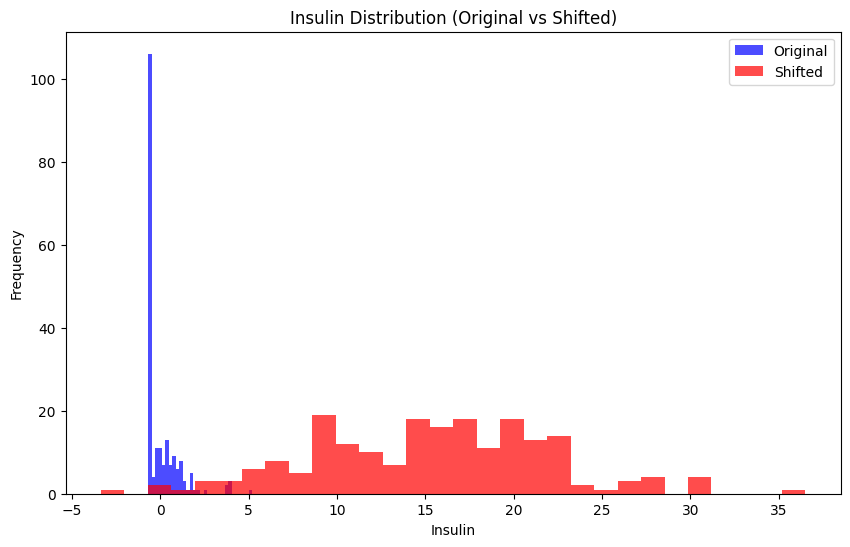

In [120]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Define transformation functions
def add_high_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_large_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature_large(data, feature, factor):
    data[feature] *= factor
    return data

def introduce_outliers(data, feature, num_outliers, outlier_value):
    indices = np.random.choice(data.index, num_outliers, replace=False)
    data.loc[indices, feature] = outlier_value
    return data

# Define a function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    return auc, accuracy, y_pred

# Prepare test data
X_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

# Log the original performance
original_auc, original_accuracy, original_pred = evaluate_model_performance(booster, X_test, y_test)
print(f"Original AUC: {original_auc}, Original Accuracy: {original_accuracy}")

# Apply transformations to Insulin
shifted_df = df.copy()
shifted_df = add_high_gaussian_noise(shifted_df, 'Insulin', mean=0, std=3)
shifted_df = add_large_bias(shifted_df, 'Insulin', bias=7)
shifted_df = scale_feature_large(shifted_df, 'Insulin', factor=2)
shifted_df = introduce_outliers(shifted_df, 'Insulin', num_outliers=10, outlier_value=20)

# Save the shifted dataset
shifted_df.to_csv('./datasets/shifted_dataset_Insulin.csv', index=False)
print('Saved shifted dataset with transformations applied to: Insulin')

# Evaluate the model on the shifted dataset
X_test_shifted = shifted_df.drop(columns=['Outcome'])
auc, accuracy, shifted_pred = evaluate_model_performance(booster, X_test_shifted, y_test)

# Perform KS test
ks_statistic, ks_pvalue = ks_2samp(df['Insulin'], shifted_df['Insulin'])

# Print results
print(f"Feature: Insulin")
print(f"AUC: Original={original_auc}, Shifted={auc}")
print(f"Accuracy: Original={original_accuracy}, Shifted={accuracy}")
print(f"KS Statistic: {ks_statistic}, p-value: {ks_pvalue}")
print("\n")

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(df['Insulin'], bins=30, alpha=0.7, color='blue', label='Original')
plt.hist(shifted_df['Insulin'], bins=30, alpha=0.7, color='red', label='Shifted')
plt.title('Insulin Distribution (Original vs Shifted)')
plt.xlabel('Insulin')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Original AUC: 0.8886998298468622, Original Accuracy: 0.81
Saved shifted dataset with transformations applied to: Glucose
Feature: Glucose
AUC: Original=0.8886998298468622, Shifted=0.7484235812231008
Accuracy: Original=0.81, Shifted=0.55
KS Statistic: 0.995, p-value: 7.770573798088942e-117




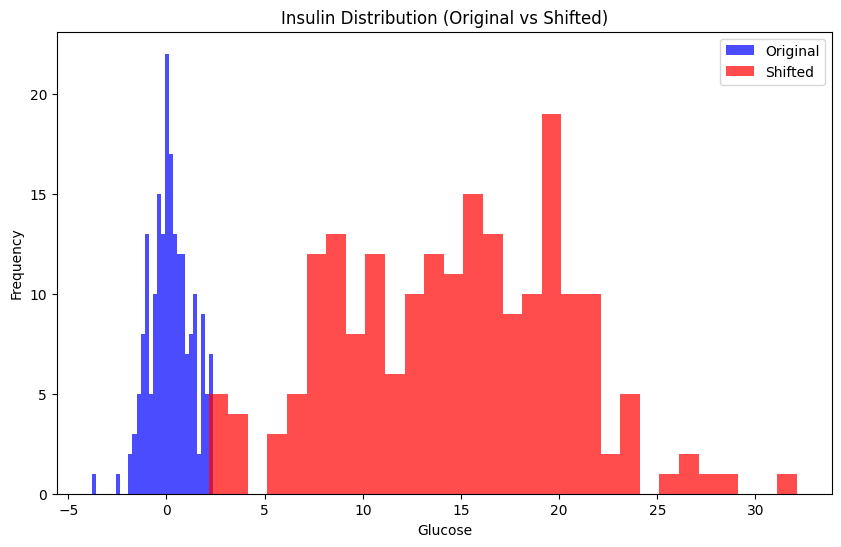

In [121]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Define transformation functions
def add_high_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_large_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature_large(data, feature, factor):
    data[feature] *= factor
    return data

def introduce_outliers(data, feature, num_outliers, outlier_value):
    indices = np.random.choice(data.index, num_outliers, replace=False)
    data.loc[indices, feature] = outlier_value
    return data

# Define a function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    return auc, accuracy, y_pred

# Prepare test data
X_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

# Log the original performance
original_auc, original_accuracy, original_pred = evaluate_model_performance(booster, X_test, y_test)
print(f"Original AUC: {original_auc}, Original Accuracy: {original_accuracy}")

# Apply transformations to Insulin
shifted_df = df.copy()
shifted_df = add_high_gaussian_noise(shifted_df, 'Glucose', mean=0, std=3)
shifted_df = add_large_bias(shifted_df, 'Glucose', bias=7)
shifted_df = scale_feature_large(shifted_df, 'Glucose', factor=2)
shifted_df = introduce_outliers(shifted_df, 'Glucose', num_outliers=10, outlier_value=20)

# Save the shifted dataset
shifted_df.to_csv('./datasets/shifted_dataset_Glucose.csv', index=False)
print('Saved shifted dataset with transformations applied to: Glucose')

# Evaluate the model on the shifted dataset
X_test_shifted = shifted_df.drop(columns=['Outcome'])
auc, accuracy, shifted_pred = evaluate_model_performance(booster, X_test_shifted, y_test)

# Perform KS test
ks_statistic, ks_pvalue = ks_2samp(df['Glucose'], shifted_df['Glucose'])

# Print results
print(f"Feature: Glucose")
print(f"AUC: Original={original_auc}, Shifted={auc}")
print(f"Accuracy: Original={original_accuracy}, Shifted={accuracy}")
print(f"KS Statistic: {ks_statistic}, p-value: {ks_pvalue}")
print("\n")

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(df['Glucose'], bins=30, alpha=0.7, color='blue', label='Original')
plt.hist(shifted_df['Glucose'], bins=30, alpha=0.7, color='red', label='Shifted')
plt.title('Insulin Distribution (Original vs Shifted)')
plt.xlabel('Glucose')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Original AUC: 0.8886998298468622, Original Accuracy: 0.81
Saved shifted dataset with transformations applied to: Pregnancies
Feature: Pregnancies
AUC: Original=0.8886998298468622, Shifted=0.8290461415273747
Accuracy: Original=0.81, Shifted=0.745
KS Statistic: 0.96, p-value: 2.942795573994628e-103




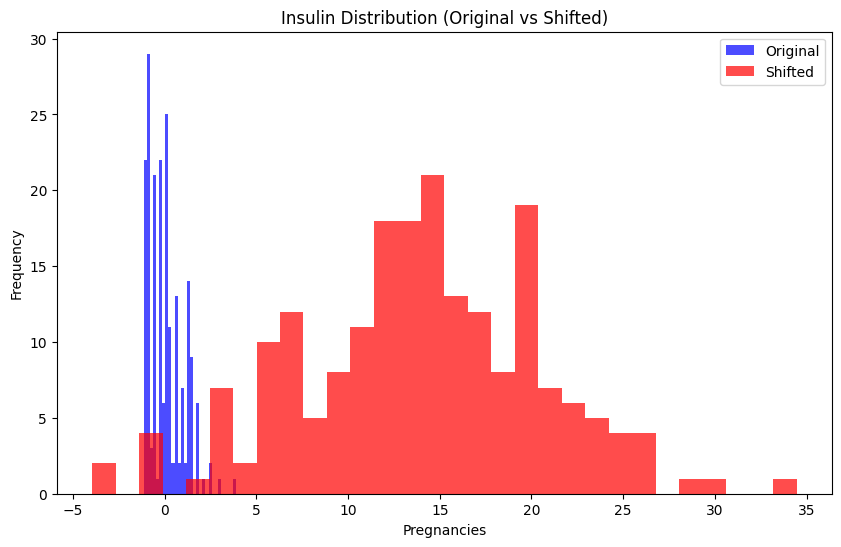

In [122]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Define transformation functions
def add_high_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_large_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature_large(data, feature, factor):
    data[feature] *= factor
    return data

def introduce_outliers(data, feature, num_outliers, outlier_value):
    indices = np.random.choice(data.index, num_outliers, replace=False)
    data.loc[indices, feature] = outlier_value
    return data

# Define a function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    return auc, accuracy, y_pred

# Prepare test data
X_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

# Log the original performance
original_auc, original_accuracy, original_pred = evaluate_model_performance(booster, X_test, y_test)
print(f"Original AUC: {original_auc}, Original Accuracy: {original_accuracy}")

# Apply transformations to Insulin
shifted_df = df.copy()
shifted_df = add_high_gaussian_noise(shifted_df, 'Pregnancies', mean=0, std=3)
shifted_df = add_large_bias(shifted_df, 'Pregnancies', bias=7)
shifted_df = scale_feature_large(shifted_df, 'Pregnancies', factor=2)
shifted_df = introduce_outliers(shifted_df, 'Pregnancies', num_outliers=10, outlier_value=20)

# Save the shifted dataset
shifted_df.to_csv('./datasets/shifted_dataset_Pregnancies.csv', index=False)
print('Saved shifted dataset with transformations applied to: Pregnancies')

# Evaluate the model on the shifted dataset
X_test_shifted = shifted_df.drop(columns=['Outcome'])
auc, accuracy, shifted_pred = evaluate_model_performance(booster, X_test_shifted, y_test)

# Perform KS test
ks_statistic, ks_pvalue = ks_2samp(df['Pregnancies'], shifted_df['Pregnancies'])

# Print results
print(f"Feature: Pregnancies")
print(f"AUC: Original={original_auc}, Shifted={auc}")
print(f"Accuracy: Original={original_accuracy}, Shifted={accuracy}")
print(f"KS Statistic: {ks_statistic}, p-value: {ks_pvalue}")
print("\n")

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(df['Pregnancies'], bins=30, alpha=0.7, color='blue', label='Original')
plt.hist(shifted_df['Pregnancies'], bins=30, alpha=0.7, color='red', label='Shifted')
plt.title('Insulin Distribution (Original vs Shifted)')
plt.xlabel('Pregnancies')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Original AUC: 0.8886998298468622, Original Accuracy: 0.81
Saved shifted dataset with transformations applied to: DiabetesPedigreeFunction
Feature: DiabetesPedigreeFunction
AUC: Original=0.8886998298468622, Shifted=0.8636773095786208
Accuracy: Original=0.81, Shifted=0.77
KS Statistic: 0.97, p-value: 1.0642884497984988e-106




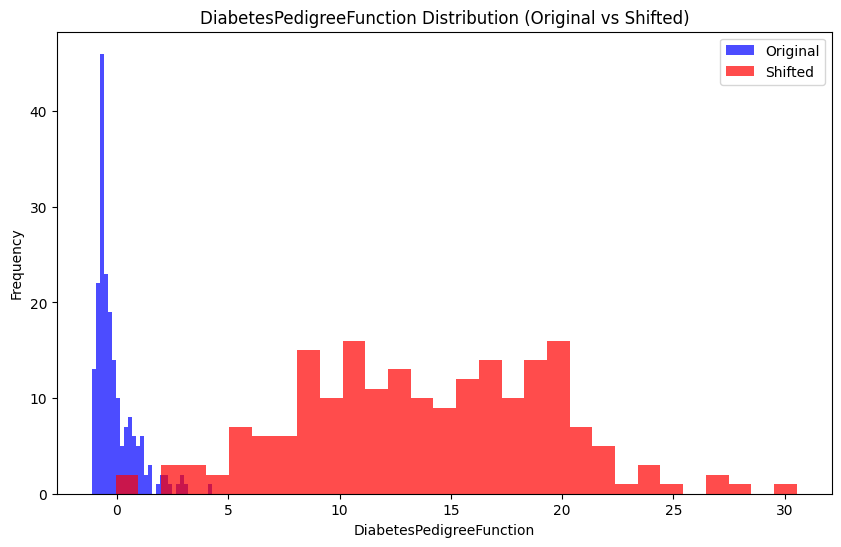

In [123]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Define transformation functions
def add_high_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_large_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature_large(data, feature, factor):
    data[feature] *= factor
    return data

def introduce_outliers(data, feature, num_outliers, outlier_value):
    indices = np.random.choice(data.index, num_outliers, replace=False)
    data.loc[indices, feature] = outlier_value
    return data

# Define a function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    return auc, accuracy, y_pred

# Prepare test data
X_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

# Log the original performance
original_auc, original_accuracy, original_pred = evaluate_model_performance(booster, X_test, y_test)
print(f"Original AUC: {original_auc}, Original Accuracy: {original_accuracy}")

# Apply transformations to Insulin
shifted_df = df.copy()
shifted_df = add_high_gaussian_noise(shifted_df, 'DiabetesPedigreeFunction', mean=0, std=3)
shifted_df = add_large_bias(shifted_df, 'DiabetesPedigreeFunction', bias=7)
shifted_df = scale_feature_large(shifted_df, 'DiabetesPedigreeFunction', factor=2)
shifted_df = introduce_outliers(shifted_df, 'DiabetesPedigreeFunction', num_outliers=10, outlier_value=20)

# Save the shifted dataset
shifted_df.to_csv('./datasets/shifted_dataset_DiabetesPedigreeFunction.csv', index=False)
print('Saved shifted dataset with transformations applied to: DiabetesPedigreeFunction')

# Evaluate the model on the shifted dataset
X_test_shifted = shifted_df.drop(columns=['Outcome'])
auc, accuracy, shifted_pred = evaluate_model_performance(booster, X_test_shifted, y_test)

# Perform KS test
ks_statistic, ks_pvalue = ks_2samp(df['DiabetesPedigreeFunction'], shifted_df['DiabetesPedigreeFunction'])

# Print results
print(f"Feature: DiabetesPedigreeFunction")
print(f"AUC: Original={original_auc}, Shifted={auc}")
print(f"Accuracy: Original={original_accuracy}, Shifted={accuracy}")
print(f"KS Statistic: {ks_statistic}, p-value: {ks_pvalue}")
print("\n")

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(df['DiabetesPedigreeFunction'], bins=30, alpha=0.7, color='blue', label='Original')
plt.hist(shifted_df['DiabetesPedigreeFunction'], bins=30, alpha=0.7, color='red', label='Shifted')
plt.title('DiabetesPedigreeFunction Distribution (Original vs Shifted)')
plt.xlabel('DiabetesPedigreeFunction')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import ks_2samp

# Load the dataset
dataset_path = './datasets/test_dataset.csv'
df = pd.read_csv(dataset_path)

# Important features and their specified transformations
transformations = {
    'Glucose': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 1.5},
    ],
    'Pregnancies': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 0.5},
    ],
    'DiabetesPedigreeFunction': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 0.65},
    ],
    'Insulin': [
        {'type': 'gaussian_noise', 'mean': 0, 'std': 0.1},
    ]
}

# Load the model
model_path = './model/xgb_model.json'
booster = xgb.Booster()
booster.load_model(model_path)

# Define transformation functions
def add_gaussian_noise(data, feature, mean, std):
    noise = np.random.normal(mean, std, data[feature].shape)
    data[feature] += noise
    return data

def add_bias(data, feature, bias):
    data[feature] += bias
    return data

def scale_feature(data, feature, factor):
    data[feature] *= factor
    return data

# Define a function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test):
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = np.where(y_pred_proba >= 0.5, 1, 0)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    return auc, accuracy, y_pred

# Prepare test data
X_test = df.drop(columns=['Outcome'])
y_test = df['Outcome']

# Log the original performance
original_auc, original_accuracy, original_pred = evaluate_model_performance(booster, X_test, y_test)
print(f"Original AUC: {original_auc}, Original Accuracy: {original_accuracy}")

# Apply transformations and evaluate performance
for feature, transformations_list in transformations.items():
    # Ensure data isolation by working on a fresh copy of the dataset
    temp_df = df.copy()
    
    # Apply each transformation in the list sequentially
    for params in transformations_list:
        if params['type'] == 'gaussian_noise':
            temp_df = add_gaussian_noise(temp_df, feature, params['mean'], params['std'])
        elif params['type'] == 'bias':
            temp_df = add_bias(temp_df, feature, params['bias'])
        elif params['type'] == 'scale':
            temp_df = scale_feature(temp_df, feature, params['factor'])
    
    # Save the shifted dataset
    temp_df.to_csv(f'./datasets/shifted_dataset_{feature}_gn.csv', index=False)
    print(f'Saved shifted dataset with transformations applied to: {feature}')
    
    # Evaluate the model on the shifted dataset
    X_test_shifted = temp_df.drop(columns=['Outcome'])
    auc, accuracy, shifted_pred = evaluate_model_performance(booster, X_test_shifted, y_test)
    
    # Perform KS test
    ks_statistic, ks_pvalue = ks_2samp(df[feature], temp_df[feature])
    
    # Print results
    print(f"Feature: {feature}")
    print(f"AUC: Original={original_auc}, Shifted={auc}")
    print(f"Accuracy: Original={original_accuracy}, Shifted={accuracy}")
    print(f"KS Statistic: {ks_statistic}, p-value: {ks_pvalue}")
    print("\n")

print("Shifting complete and datasets saved.")


Original AUC: 0.8886998298468622, Original Accuracy: 0.81
Saved shifted dataset with transformations applied to: Glucose
Feature: Glucose
AUC: Original=0.8886998298468622, Shifted=0.8082274046641977
Accuracy: Original=0.81, Shifted=0.72
KS Statistic: 0.19, p-value: 0.0014264303851701861


Saved shifted dataset with transformations applied to: Pregnancies
Feature: Pregnancies
AUC: Original=0.8886998298468622, Shifted=0.8875988389550595
Accuracy: Original=0.81, Shifted=0.81
KS Statistic: 0.105, p-value: 0.220541217580421


Saved shifted dataset with transformations applied to: DiabetesPedigreeFunction
Feature: DiabetesPedigreeFunction
AUC: Original=0.8886998298468622, Shifted=0.8882994695225703
Accuracy: Original=0.81, Shifted=0.815
KS Statistic: 0.175, p-value: 0.004304993380033157


Saved shifted dataset with transformations applied to: Insulin
Feature: Insulin
AUC: Original=0.8886998298468622, Shifted=0.8899009108197378
Accuracy: Original=0.81, Shifted=0.815
KS Statistic: 0.3, p-value